# 🏡 Finding Drivers of Zestimate Errors - Exploration Notebook
---

This notebook serves as a guide to the data science process up to and including all aspects of exploration and feature creation. This is the sibling notebook to `modeling.ipynb` which contains the remaining process through model testing. This may serve as additional resource for insights found in the `final_report.ipynb` or as a guide for project reproduction.

**⏯ Initialize Notebook**

In [1]:
# import standard libraries
import pandas as pd
import numpy as np

# import visualization tools
import matplotlib.pyplot as plt
import seaborn as sns

# import clustering and metric tools
import scipy.stats as stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# import created scripts
import acquire
import prepare
import explore
from wrangle import wrangle_zillow

# cosmetic imports and settings
import warnings
warnings.filterwarnings("ignore")
from matplotlib.pyplot import style
style.use('~/.matplotlib/gruvbox.mplstyle')
from end import end

## 🔹 Data Acquisition
---
### Prepare to Prepare

For this project, we will be treading over data that was used previously to create model predictions for property values. This same data will be used in a different way in order to predict and find drivers of the `logerror`, the difference between predicted value, or Zillow "Zestimate", and the true value of the property. Below you can find a detailed step-by-step of how the data was acquired for preparation.

In [2]:
# create variable to hold SQL query
query = '''
    SELECT *, properties_2017.id AS property_id
    FROM properties_2017
    INNER JOIN predictions_2017
        USING(parcelid)
    LEFT OUTER JOIN airconditioningtype
        USING(airconditioningtypeid)
    LEFT OUTER JOIN architecturalstyletype
        USING(architecturalstyletypeid)
    LEFT OUTER JOIN buildingclasstype
        USING(buildingclasstypeid)
    LEFT OUTER JOIN heatingorsystemtype
        USING(heatingorsystemtypeid)
    LEFT OUTER JOIN propertylandusetype
        USING(propertylandusetypeid)
    LEFT OUTER JOIN storytype
        USING(storytypeid)
    LEFT OUTER JOIN typeconstructiontype
        USING(typeconstructiontypeid)
    LEFT OUTER JOIN unique_properties
        USING(parcelid)
    WHERE
        transactiondate LIKE '2017%%' AND
        latitude IS NOT NULL AND
        longitude IS NOT NULL;'''

In [3]:
# read in initial DataFrame
df = acquire.get_sql(query, 'zillow')

In [4]:
# remove duplicate properties keeping most recent sell date
df = df.sort_values('transactiondate').drop_duplicates('parcelid', keep='last')

In [5]:
# create list of single unit propertylandusedesc
single_prop_types = ['Single Family Residential', 'Condominium', 'Mobile Home',
                     'Manufactured, Modular, Prefabricated Homes', 'Townhouse']
# filter for most-likely single unit properties
df = df[df.propertylandusedesc.isin(single_prop_types)]
df = df[(df.bedroomcnt > 0) & (df.bedroomcnt <= 10)]
df = df[(df.bathroomcnt > 0) & (df.bathroomcnt <= 10)]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71270 entries, 0 to 77578
Data columns (total 70 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      71270 non-null  int64  
 1   typeconstructiontypeid        222 non-null    float64
 2   storytypeid                   47 non-null     float64
 3   propertylandusetypeid         71270 non-null  float64
 4   heatingorsystemtypeid         46311 non-null  float64
 5   buildingclasstypeid           0 non-null      float64
 6   architecturalstyletypeid      206 non-null    float64
 7   airconditioningtypeid         22857 non-null  float64
 8   id                            71270 non-null  int64  
 9   basementsqft                  47 non-null     float64
 10  bathroomcnt                   71270 non-null  float64
 11  bedroomcnt                    71270 non-null  float64
 12  buildingqualitytypeid         44756 non-null  float64
 13  c

### 🔥 Finish Acquiring

As was already expected, many of the observations are missing data from numerous columns, some with as many as 100% such as `buildingclassdesc`. These missing values will be dealt with by dropping and imputing in preparation.

## 🔹 Data Preparation
---

### Dropping Columns and Rows

There are many columns that are missing substantial amounts of data from the total observations. Those with more than 25% missing data will be dropped outright. We will also drop redundant columns and any column with no known context or is incorrectly labeled. For this project we are wanting to look at values with `transactiondates` and `logerrors` from the `predictions_2017` table in the `zillow` database. Below you can see each step as columns are dropped due to redundancy, lack of context clarity, and insufficient values.

In [7]:
# set drop unnecessary id columns
df = df.drop(columns=['id', 'id.1'])
# drop -typeid columns that are redundant to desc columns
df = df.drop(columns=(df.filter(regex='typeid').columns))
# drop regionid- columns that are not well defined
df = df.drop(columns=(df.filter(regex='regionid').columns))
# drop columns with no clear context, redundant values
df = df.drop(columns=['assessmentyear', 'calculatedbathnbr', 'finishedsquarefeet12',
                      'propertycountylandusecode', 'propertylandusedesc',
                      'rawcensustractandblock', 'roomcnt'])

In [8]:
# drop columns and rows missing more than 25% of total observation data
df = prepare.drop_null_values(df)

In [9]:
# drop all rows with null values for any tax fields
df = df[df.taxvaluedollarcnt.isnull() == False]
df = df[df.landtaxvaluedollarcnt.isnull() == False]
df = df[df.structuretaxvaluedollarcnt.isnull() == False]
df = df[df.taxamount.isnull() == False]

In [10]:
# drop the low-count of null rows rather than impute
df = df[df.fullbathcnt.isnull() == False]
df = df[df.yearbuilt.isnull() == False]
df = df[df.calculatedfinishedsquarefeet.isnull() == False]
df = df[df.censustractandblock.isnull() == False]

### Improve Data Legibility

Having removed unnecessary and complicating data, from here it will be adjusted for ease of comprehension. Column names will be renamed for clarity, FIPS codes will be transformed to human readable county names to be encoded into separate columns, and data types will be converted to the appropriate type for the values held. Lastly, all columns will be ordered alphabetically for ease of finding in mass visuals and .info() searches.

In [11]:
# convert to drop float decimals
df.fips = df.fips.astype(int)
# replace fips numerical codes with string county names and rename column
df.fips = np.where(df.fips == 6037, 'Los Angeles', df.fips)
df.fips = np.where(df.fips == '6059', 'Orange', df.fips)
df.fips = np.where(df.fips == '6111', 'Ventura', df.fips)
# rename column to reflect new values
df = df.rename(columns=({'fips':'county'}))

In [12]:
# convert columns to correct data type
df.transactiondate = pd.to_datetime(df.transactiondate)
df.bedroomcnt = df.bedroomcnt.astype(int)
df.yearbuilt = df.yearbuilt.astype(int)

In [13]:
# convert latitude and longitude from whole numbers to coords
df.latitude = df.latitude / 1_000_000
df.longitude = df.longitude / 1_000_000

In [14]:
# rename columns
col_dict = {'bathroomcnt':'bathrooms', 
            'bedroomcnt':'bedrooms', 
            'calculatedfinishedsquarefeet':'structure_square_feet',
            'censustractandblock':'census_tractcode',
            'fullbathcnt':'full_bathrooms',
            'landtaxvaluedollarcnt':'land_value_usd',
            'logerror':'log_error',
            'lotsizesquarefeet':'lot_square_feet',
            'parcelid':'parcel_id',
            'structuretaxvaluedollarcnt':'structure_value_usd',
            'taxamount':'tax_amount_usd',
            'taxvaluedollarcnt':'property_value_usd',
            'transactiondate':'transaction_date',
            'yearbuilt':'year_built'
           }
df = df.rename(columns=col_dict)
# reorganized columns alphabetically for readability
cols = list(df)
cols.sort()
df = df[cols]

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70939 entries, 0 to 77578
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   bathrooms              70939 non-null  float64       
 1   bedrooms               70939 non-null  int64         
 2   census_tractcode       70939 non-null  float64       
 3   county                 70939 non-null  object        
 4   full_bathrooms         70939 non-null  float64       
 5   land_value_usd         70939 non-null  float64       
 6   latitude               70939 non-null  float64       
 7   log_error              70939 non-null  float64       
 8   longitude              70939 non-null  float64       
 9   lot_square_feet        63067 non-null  float64       
 10  parcel_id              70939 non-null  int64         
 11  property_id            70939 non-null  int64         
 12  property_value_usd     70939 non-null  float64       
 13  s

### Distributions and Outliers

Now that the data is just about ready for exploration, the distributions will be visualized in order to check for any significant outliers that may be problematic to modeling in later phases. Variables who have significant skew will be adjusted to discard outliers that lie sufficiently outside the Interquartile range.

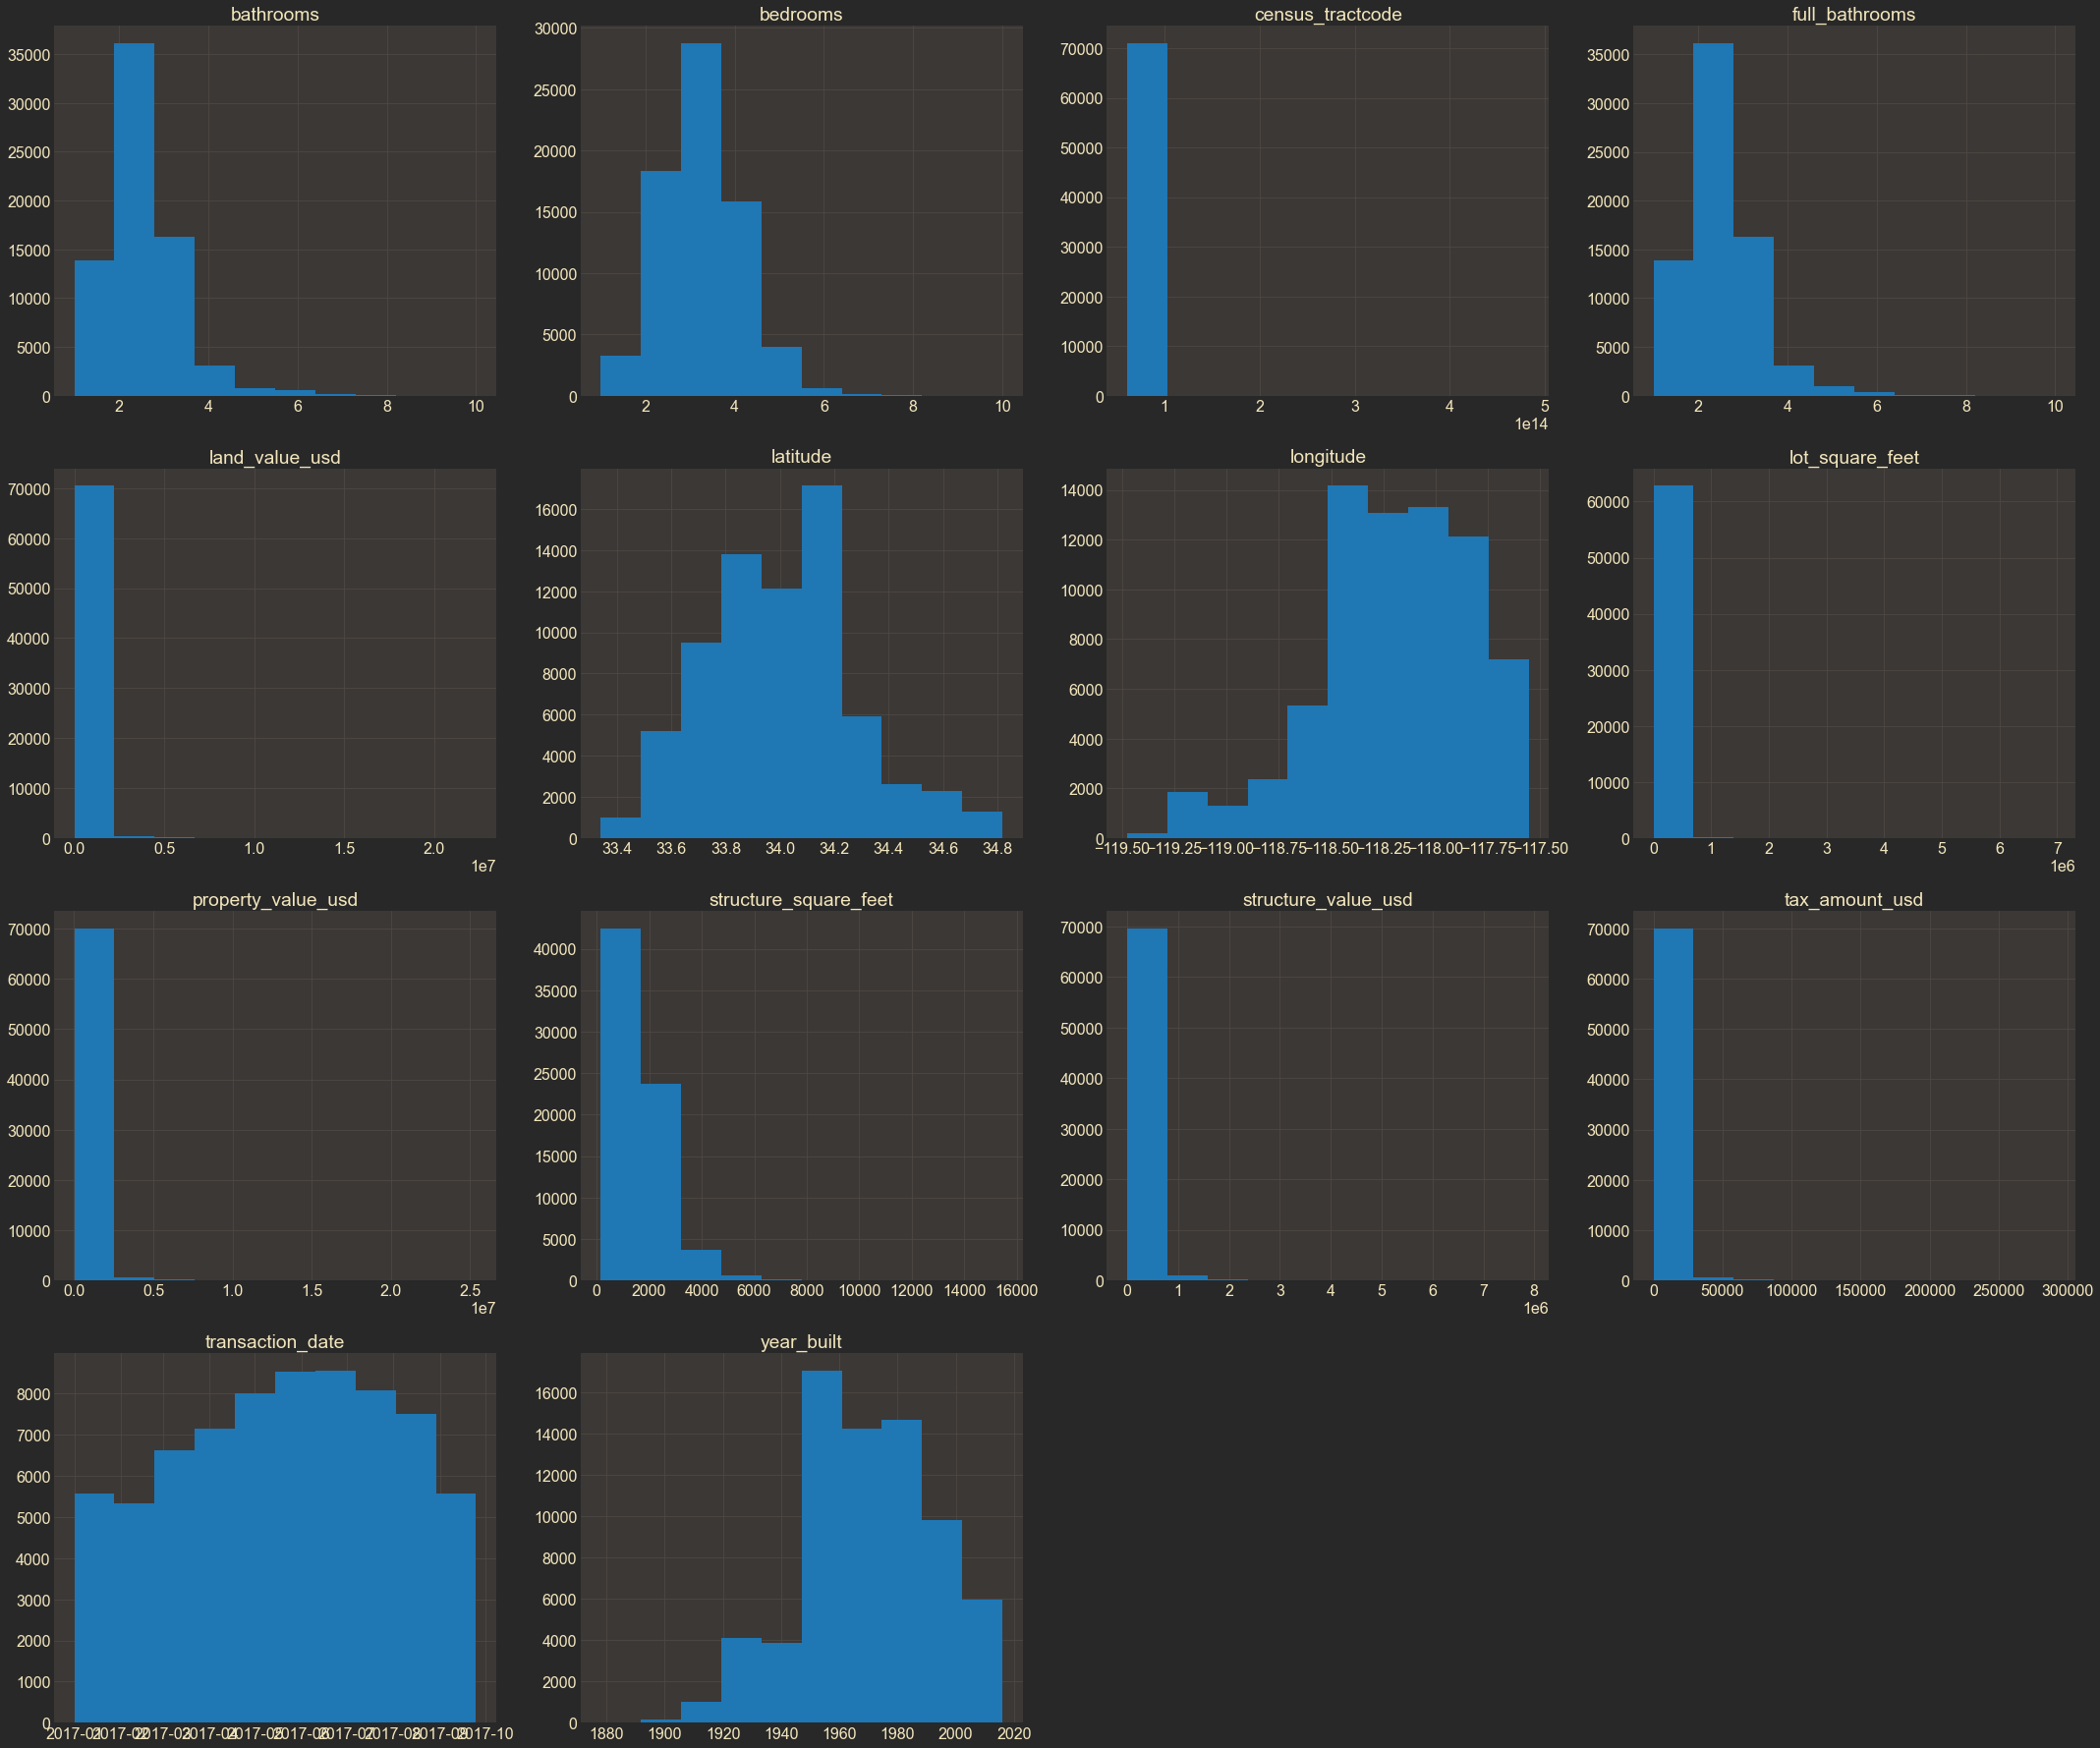

In [16]:
# visualize distributions
df.drop(columns=['log_error', 'parcel_id', 'property_id']).hist(figsize=(30,25))
plt.tight_layout()
plt.show()

In [17]:
# assign columns to remove IQR outliers from
outlier_cols = ['land_value_usd', 'property_value_usd',
                'structure_square_feet', 'tax_amount_usd']
# run function to remove rows with outlier values
df = prepare.shed_iqr_outliers(df, col_list=outlier_cols)

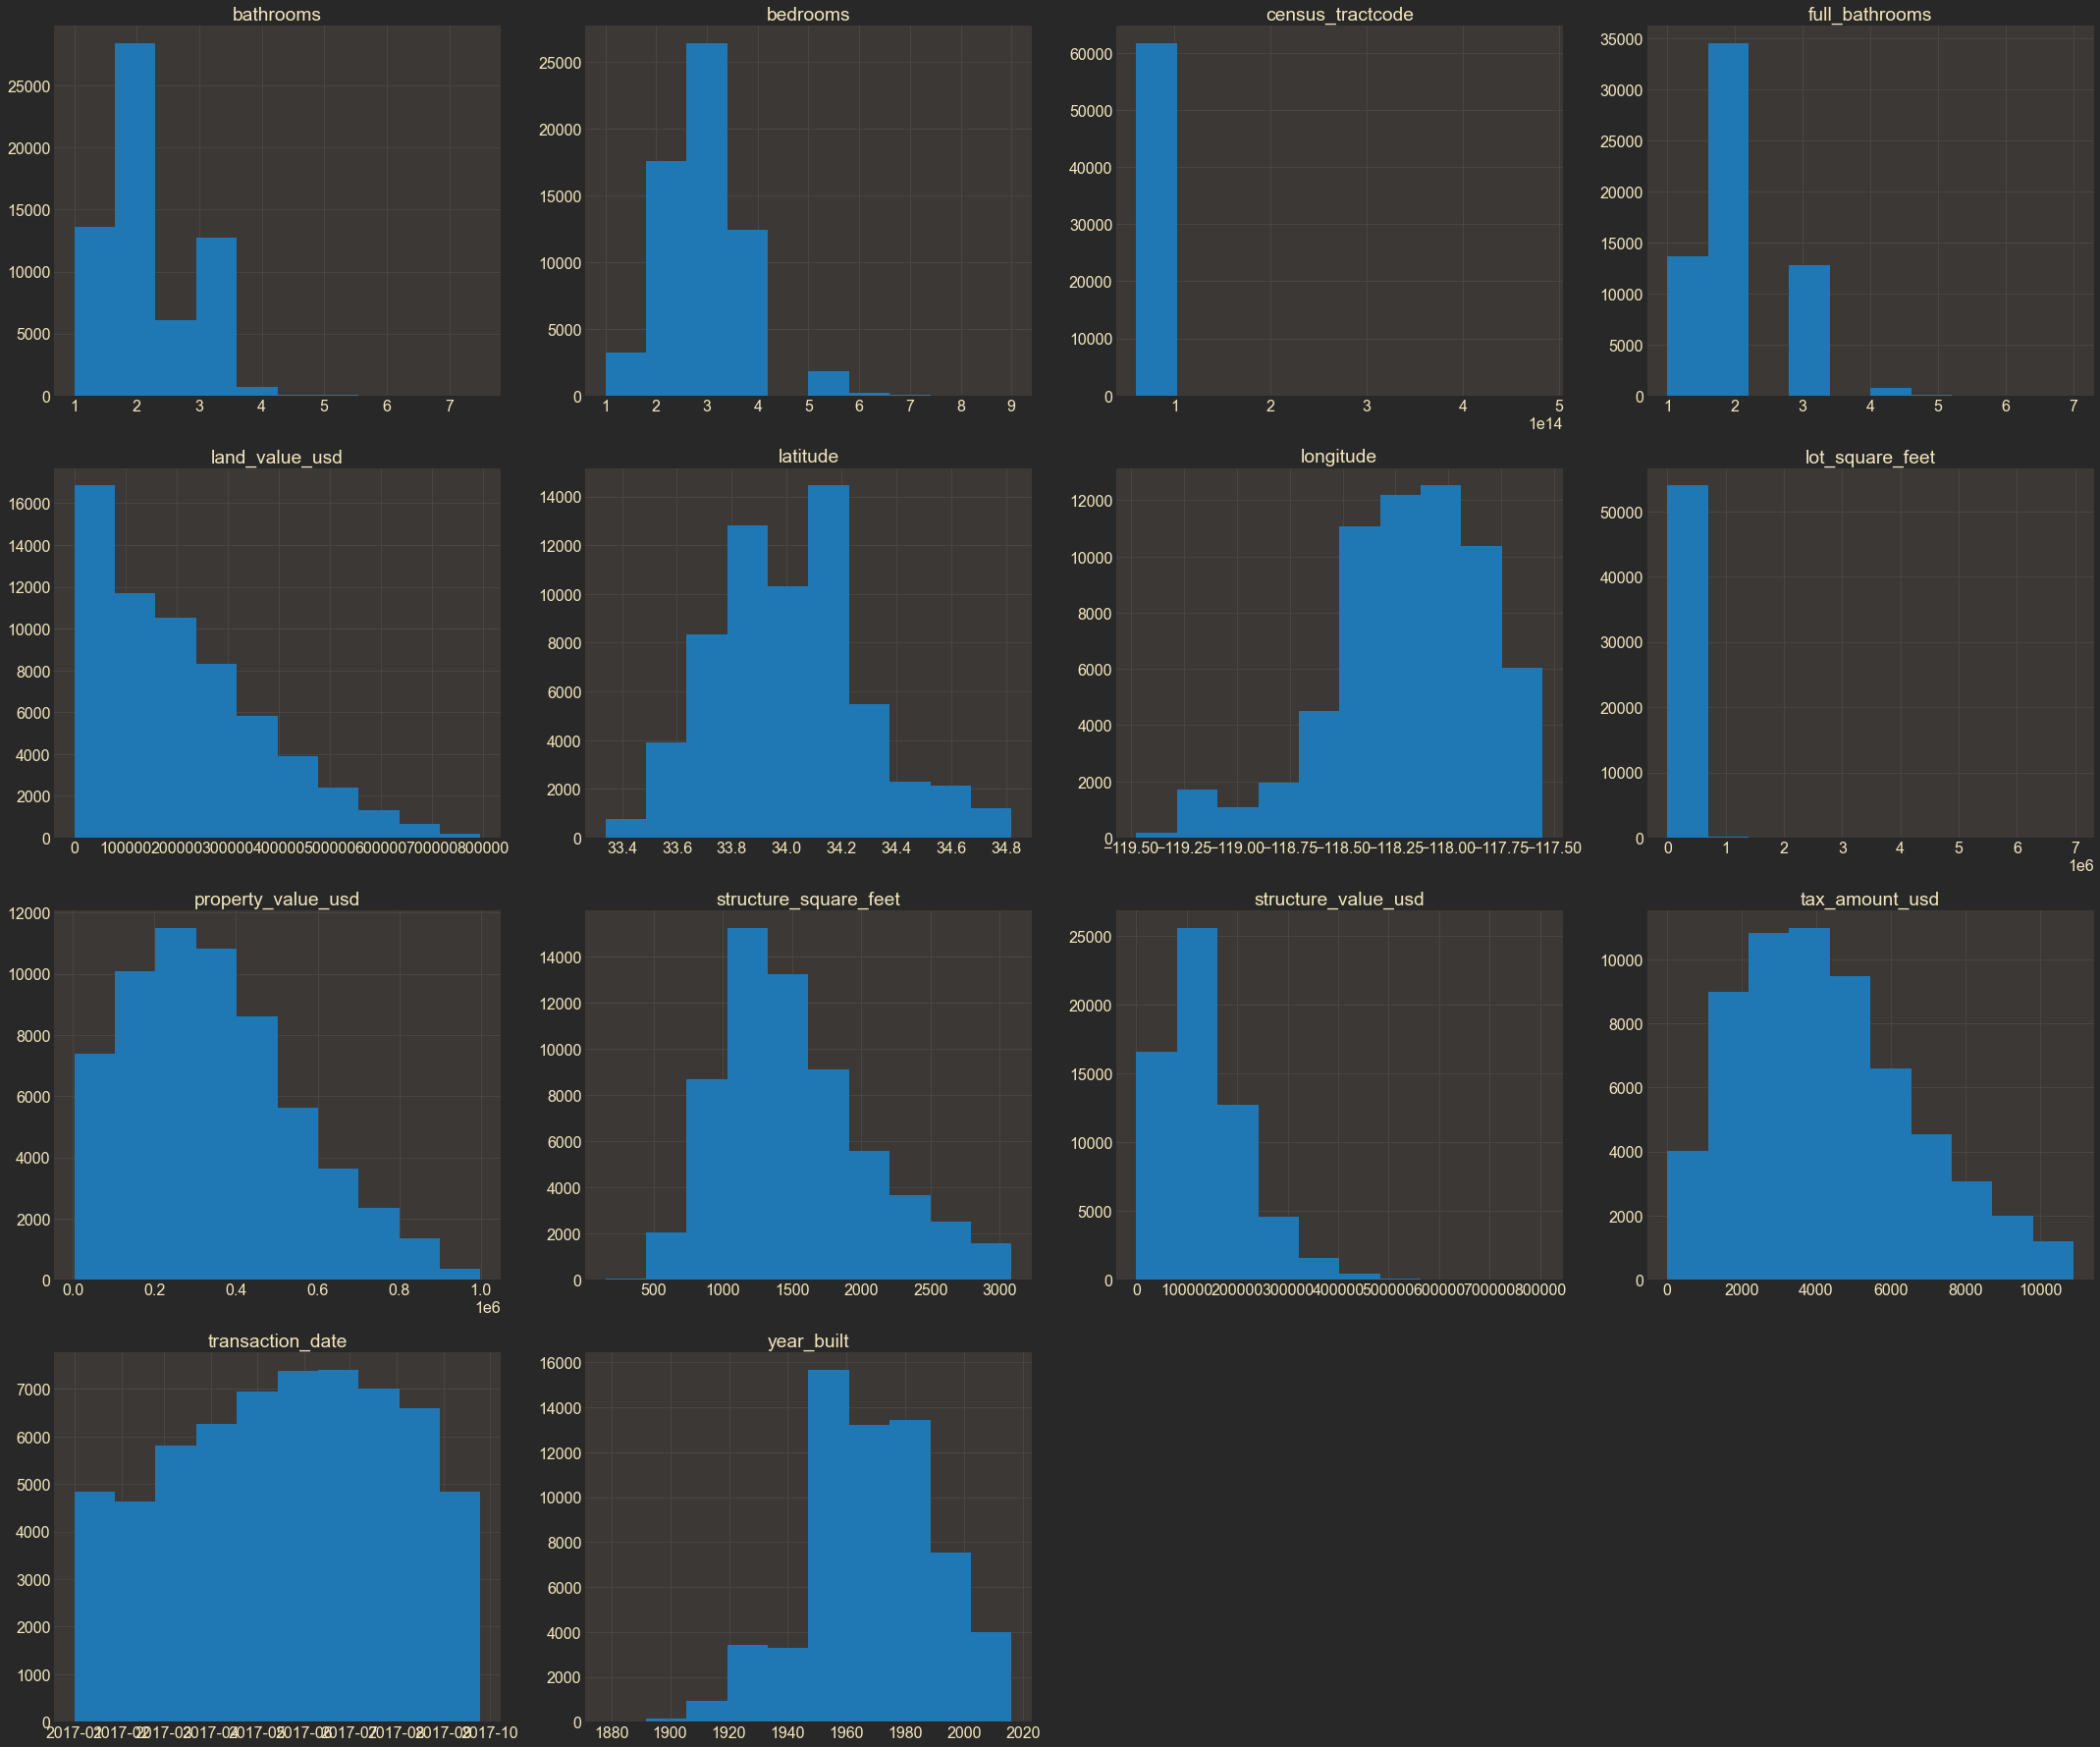

In [18]:
# visualize distributions after outlier removal
df.drop(columns=['log_error', 'parcel_id', 'property_id']).hist(figsize=(30,25))
plt.tight_layout()
plt.show()

In [19]:
df.shape

(61661, 18)

### 🔥 Prepare Takeaways

It can be seen that the distribution skews of the four columns adjusted for outliers have improved quite dramatically. The `lot_square_feet` column has not been adjusted for outliers as it will have missing values imputed with the column mean in the next phase. If this presents as an issue, the variable will not be used as a feature in modeling.

## 🔹 Data Exploration
---

Now that the data is prepared, it is time to begin thoroughly exploring it. Firstly, the `wrangle_zillow` function will be used to read in the data. This function will perform all the steps outlined in data acquisition and preparation, and will output DataFrames containing the X, y split data for `train`, `validate`, and `test` data sets.

In [20]:
# acquire prepared data for exploration and future modeling
X_train, y_train, \
X_validate, y_validate, \
X_test, y_test = wrangle_zillow(clusters=False)


*----------------------------------------*
|  ***   Data Preparation Summary   ***  |
*----------------------------------------*
|                                        |
|       Initial Observations: 77,579     |
|      Prepared Observations: 61,625     |
|          Null Loss Percent: 20.56%     |
|                                        |
|       X_train Observations: 36,975     |
|           Percent of Total: 48%        |
|               Percent of X: 60%        |
|                                        |
|    X_validate Observations: 12,325     |
|           Percent of Total: 16%        |
|               Percent of X: 20%        |
|                                        |
|        X_test Observations: 12,325     |
|           Percent of Total: 16%        |
|               Percent of X: 20%        |
|                                        |
*~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~*


In [21]:
X_train.shape, X_validate.shape, X_test.shape

((36975, 25), (12325, 25), (12325, 25))

In [22]:
# combine target to DataFrame for exploration
train = pd.concat((X_train, y_train.log_error), axis=1)

## Initial Thoughts and Hypotheses

It seems reasonable that when considering the meaning of the `log_error`, $log$_$error = log(Zestimate) - log(SalePrice)$, that the importance of the location of the property is not being appropriately valued due to the subjective nature of "good" versus "bad" neighborhoods.

**Initial Hypotheses**
- H$_0$: There is no significant difference in `log_error` based on property location. 
- H$_a$: There is  a significant difference in `log_error` based on property location.

### Plotting and Statistical Tests

The variables in the data set will be visualized and compared for analysis of relationship to the target. Any notable observations will be detailed below after investigating.

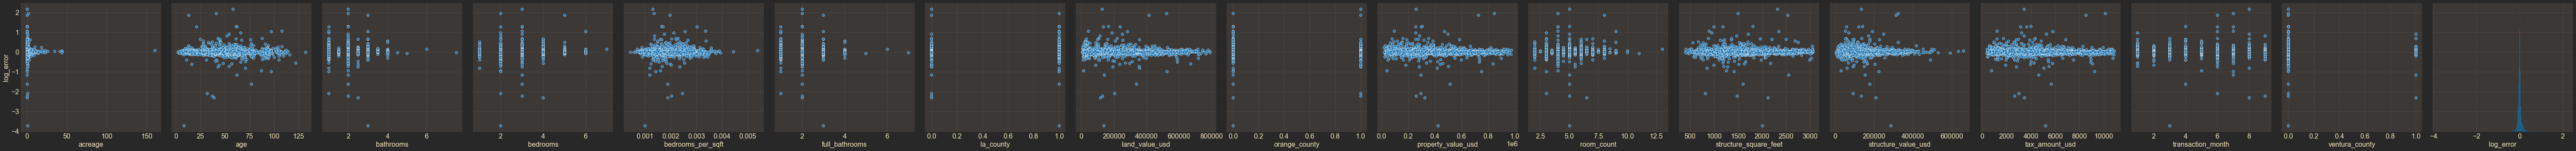

In [23]:
# create a pairplot for quick glance at variable interaction
sns.pairplot(train.drop(
    columns=['census_tractcode', 'county', 'latitude', 'longitude',
             'lot_square_feet', 'parcel_id', 'property_id', 'year_built'])\
             .sample(n=3000, random_state=19), y_vars=['log_error'], height=5, aspect=1)

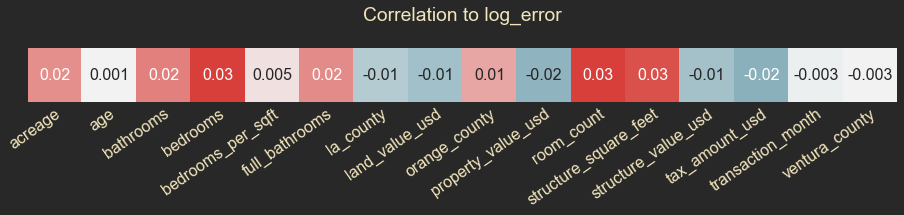

In [24]:
# create heatmap to find any obvious correlations to target
explore.target_heat(train.drop(
    columns=['census_tractcode', 'county', 'latitude', 'longitude',
             'lot_square_feet', 'parcel_id', 'property_id', 'year_built']), 'log_error')

#### Hypothesis Testing Correlation to Target

There seems to be a correlation present, but before stating as much there needs to be a statistical test to show the correlation isn't due to chance. Below are the defined hypotheses for these tests, and then a correlation test will be performed against the predetermined significance level.

- H$_0$: There is no linear correlation between the variables and log_error.
- H$_a$: There is a  linear correlation between the variables and log_error.
- $\alpha$: 0.05

In [25]:
# perform statistical tests on strongest correlations according to heatmap
explore.corr_test(train, 'bedrooms', 'log_error')
explore.corr_test(train, 'structure_square_feet', 'log_error')
explore.corr_test(train, 'property_value_usd', 'log_error')
explore.corr_test(train, 'tax_amount_usd', 'log_error')

   pearson r = 0.029
+--------------------+

        Due to p-value 1.9e-08 being less than our significance level of 0.05, we may reject the null hypothesis 
        that there is not a linear correlation between "bedrooms" and "log_error."
        
   pearson r = 0.026
+--------------------+

        Due to p-value 3.5e-07 being less than our significance level of 0.05, we may reject the null hypothesis 
        that there is not a linear correlation between "structure_square_feet" and "log_error."
        
   pearson r = -0.017
+--------------------+

        Due to p-value 0.0012 being less than our significance level of 0.05, we may reject the null hypothesis 
        that there is not a linear correlation between "property_value_usd" and "log_error."
        
   pearson r = -0.018
+--------------------+

        Due to p-value 0.0006 being less than our significance level of 0.05, we may reject the null hypothesis 
        that there is not a linear correlation between "tax_amoun

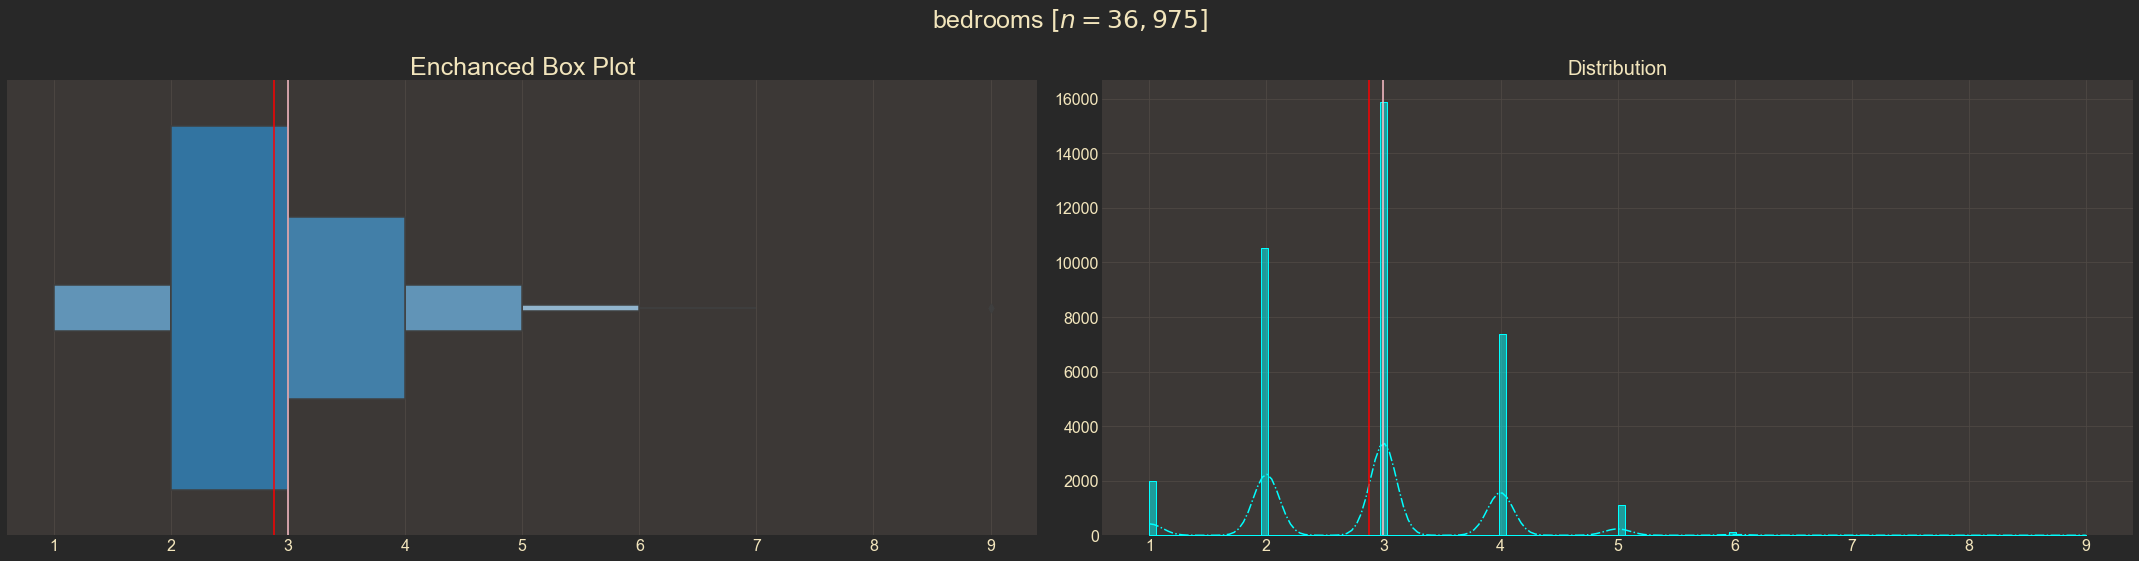

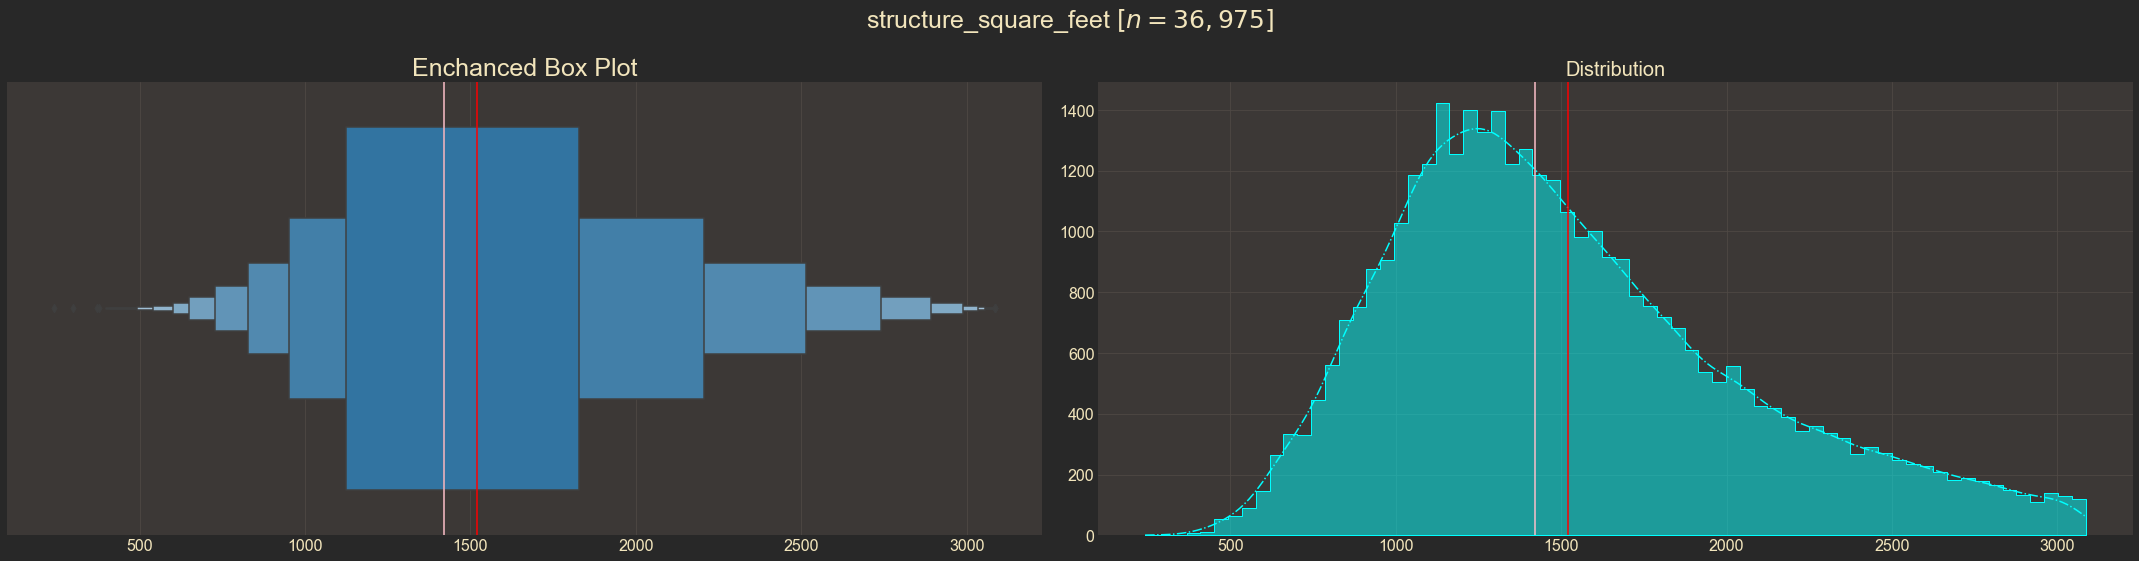

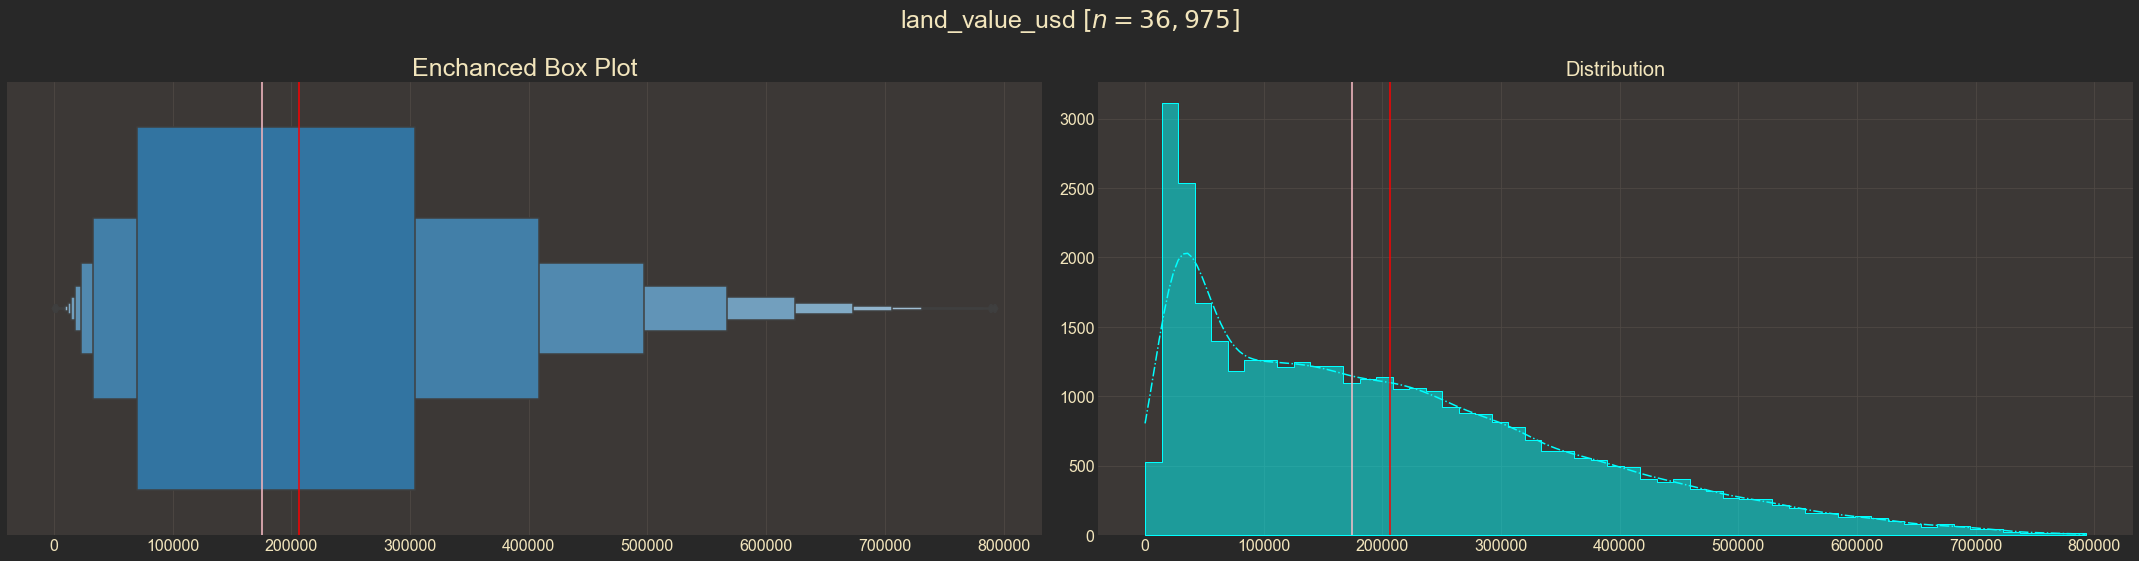

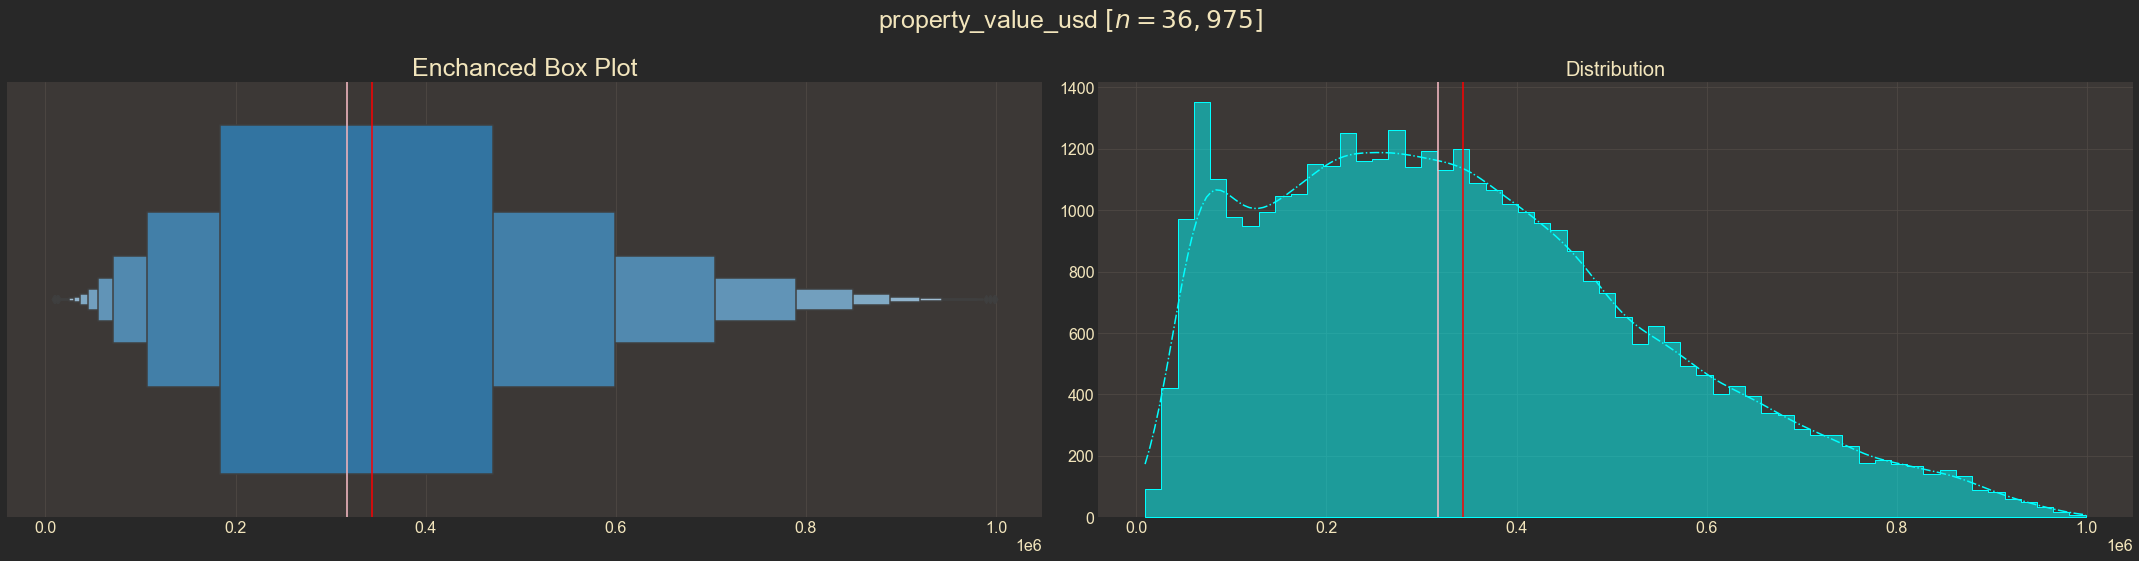

In [26]:
# look more closely at strongest correlations to log_error
explore.plot_univariate(train, 'bedrooms')
explore.plot_univariate(train, 'structure_square_feet')
explore.plot_univariate(train, 'land_value_usd')
explore.plot_univariate(train, 'property_value_usd')

#### 🔥 Initial Thoughts Reflection

Looking at the plot of variables to the target `log_error`, there is no obvious relationship present with the individual variables. Looking at the pairplot, all of the variables show significant range in `log_error` for each. There is no strong correlation between the target and other variables. The only thing that can be said as far as relationships go is that there is statistically significant negative correlation in `land_value_usd` and `property_value_usd` with the target. There is also a positive correlation between `room_count` and `structure_square_feet` with the target. It is possible that the way the variables interact is driving the changes to `log_error`. Clustering will be used to attempt to find a possible relationship.

### Cluster Exploration

Using the initial hypotheses and thoughts as a guide, clustering will be used to combine features to find a meaningful expression of what may be driving `log_error`. Several attempts will be made at combining the variables in exploration to find clusters that may show insights in the drivers and possibly be carried over into modeling for predictions.  From there, the clusters will be compared using an analysis of variance (ANOVA) test. Due to `log_error` not being considered by the `KMeans` algorithm, variance comparison of that target should be safe to perform.

#### Latitude & Longitude

As stated in the initial thoughts section, it was hypothesized that location would play a role in under or over estimating the value of properties. Below the relationship of location via latitude and longitude will be explored. Due to the significant amount of time geocoding would take, this method will use clustering where $k$ is the point of minimal change to inertia according to plotting using the elbow method.

**Hypotheses and Significance Level**
- H$_0$: There is no significant difference in `log_error` between cluster groups for `latitude` and `longitude`.
- H$_a$: There is a  significant difference in `log_error` between cluster groups for `latitude` and `longitude`.
- $\alpha$: 0.05

In [27]:
# set col_list for cluster formation
col_list = ['latitude', 'longitude']
# create DataFrame for explored variables
explore_df = train[col_list]
# scale data for distance in kmeans
scaler = StandardScaler()
scaled = scaler.fit_transform(explore_df)
explore_df = pd.DataFrame(scaled, columns=explore_df.columns, index=explore_df.index)

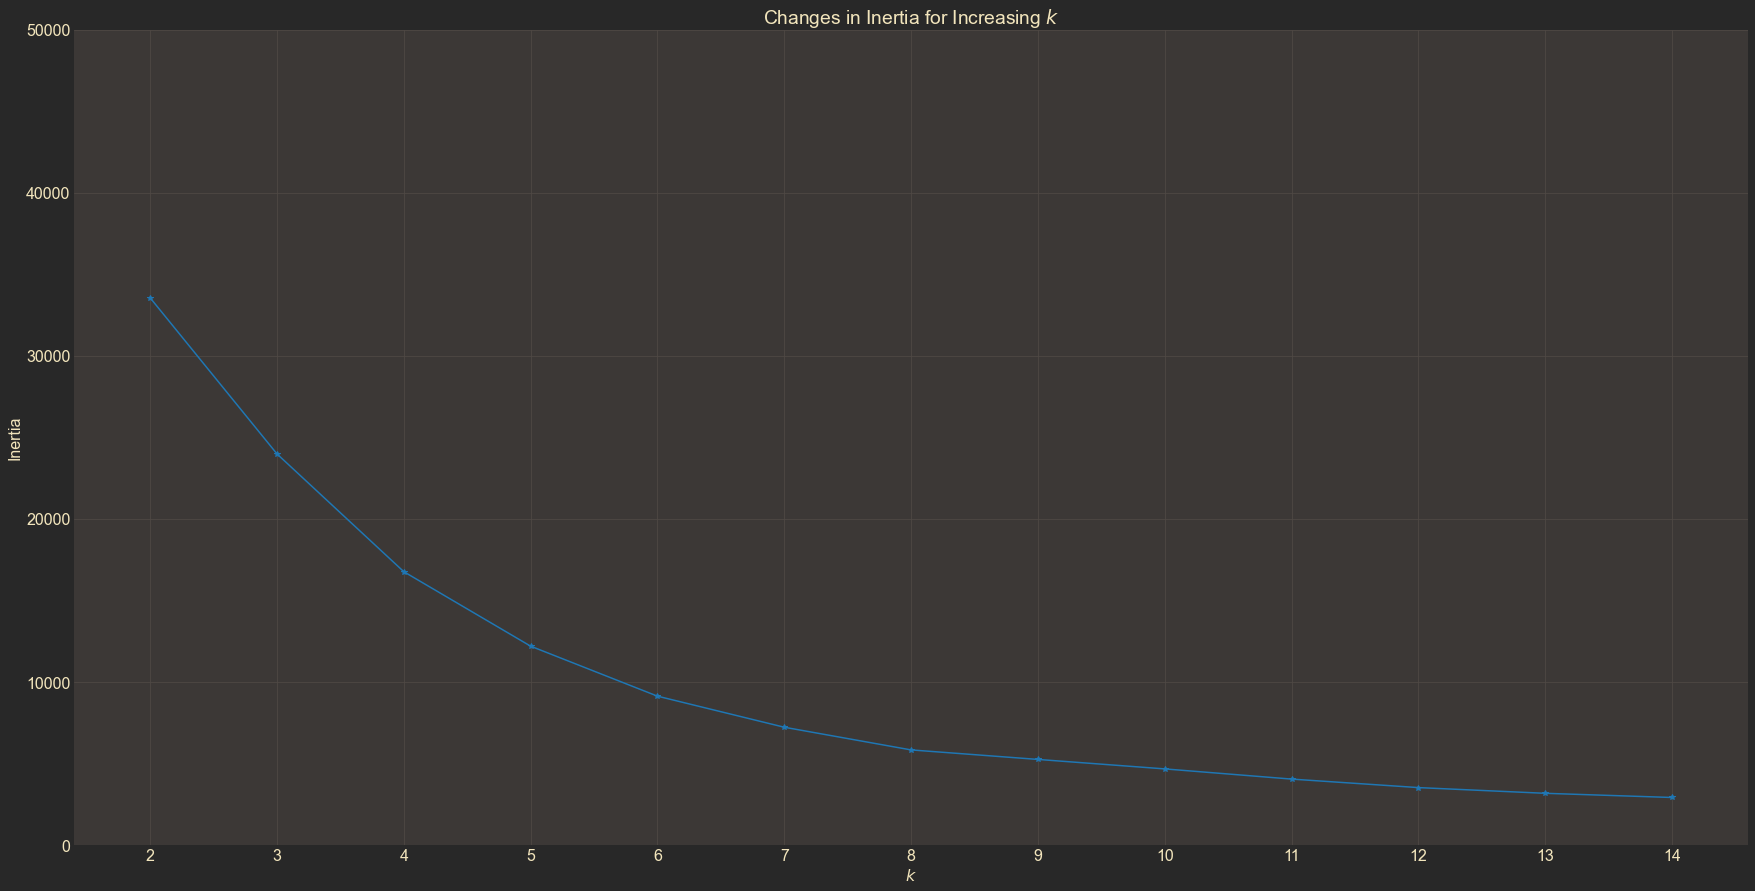

In [28]:
# create plot to use elbow method to find best k
explore.elbow_plot(explore_df, col_list)

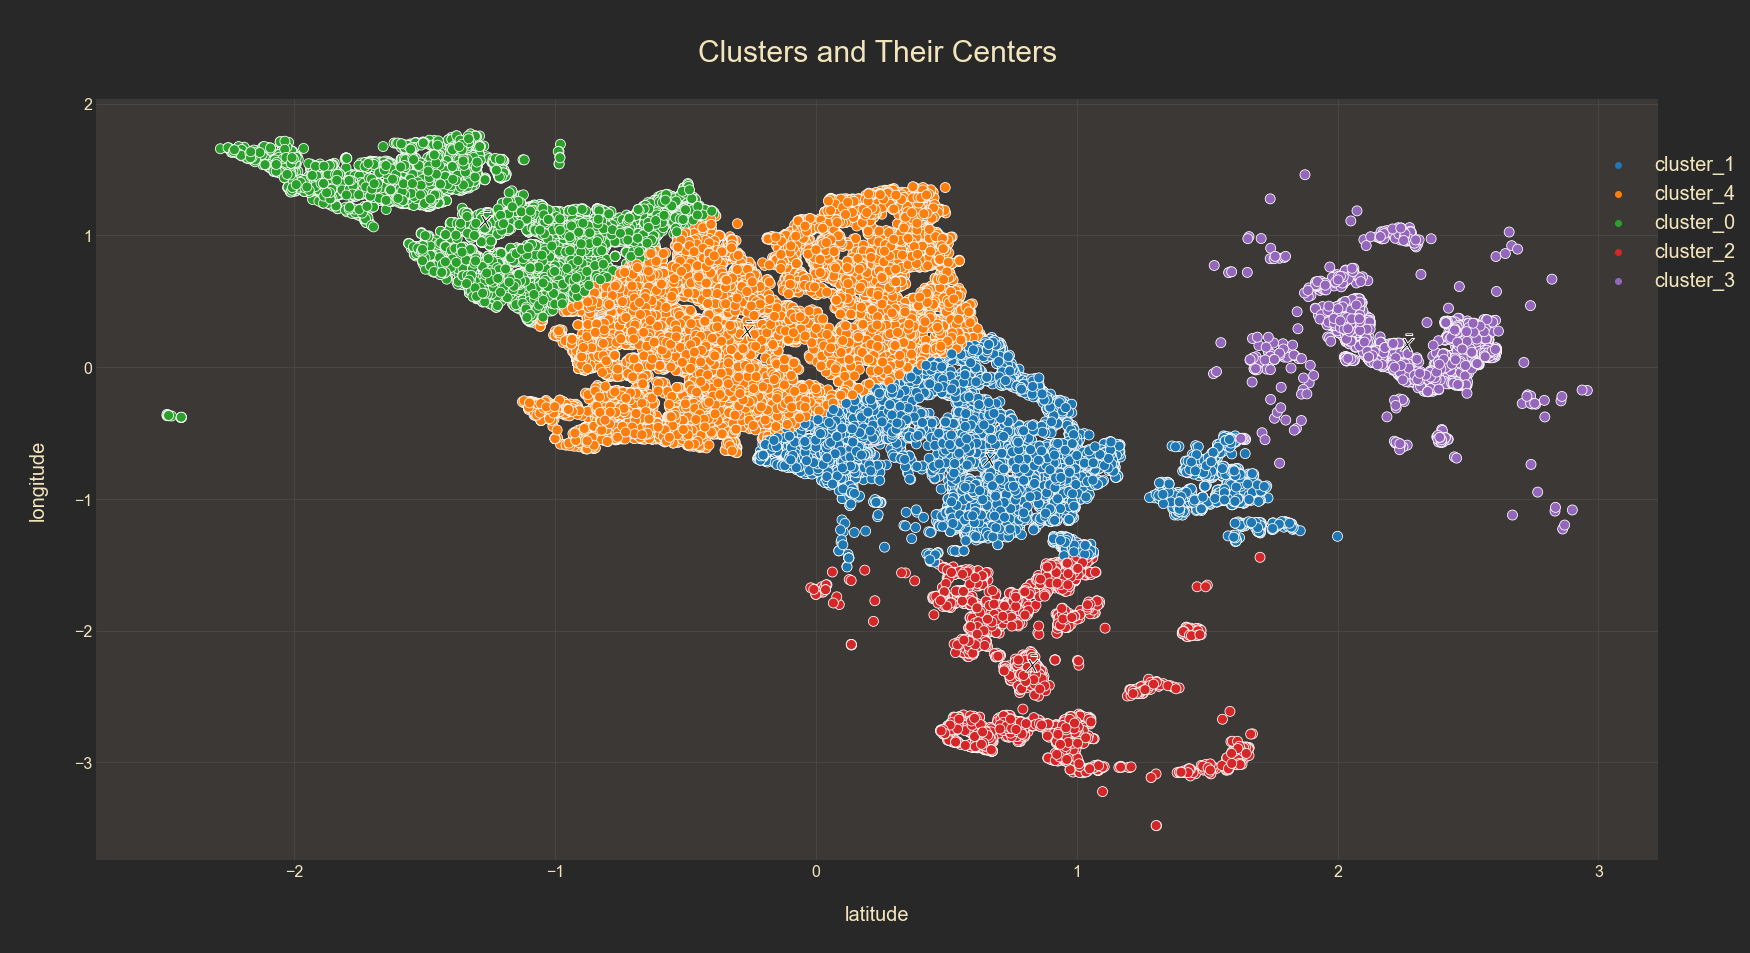

In [29]:
# create clusters for exploring log_error relative to location
cluster_df, center_df, kmeans = explore.explore_clusters(explore_df, col_list, k=5)
# create plot to view clusters for lat_long_clstr
explore.plot_clusters(cluster_df, center_df, 'latitude', 'longitude')

In [30]:
# set alpha for testing significance
alpha = 0.05
# create DataFrame of samples for ANOVA testing
samples = pd.concat((cluster_df, train.log_error), axis=1)
# Perform ANOVA one-way test for null hypotesis
F, p = stats.f_oneway(samples[samples.cluster == 0].log_error,
                      samples[samples.cluster == 1].log_error,
                      samples[samples.cluster == 2].log_error,
                      samples[samples.cluster == 3].log_error,
                      samples[samples.cluster == 4].log_error)
# print fail or succeed to reject and values returned
if p < alpha:
    state = '✓ May reject'
else:
    state = '𐄂 Fail to reject'
print(f'''
      Stats
+---------------+
| F-value: {F:.2f} |  {state}
| p-value: {p:.2f} |  the null hypothesis.
+---------------+
''')


      Stats
+---------------+
| F-value: 3.55 |  ✓ May reject
| p-value: 0.01 |  the null hypothesis.
+---------------+



##### 🔥 Results

Performing the analysis of variance test, there is a significant difference in the populations using five cluster for longitude and latitude.

In [31]:
# add cluster to DataFrame for feature exploration
train['lat_long_clstr'] = cluster_df.cluster
train = pd.get_dummies(train, columns=['lat_long_clstr'], drop_first=True)

#### Lot Size & Room Count

Striking out with the initial hypothesis, below the relationship of count of bedrooms and bathrooms will be clustered with size of lot in acres and explored against the target. The clusters will then be compared using an ANOVA test.

**Hypotheses and Significance Level**
- H$_0$: There is no significant difference in `log_error` between cluster groups for `acreage` and `room_count`.
- H$_a$: There is a  significant difference in `log_error` between cluster groups for `acreage` and `room_count`.
- $\alpha$: 0.05

In [32]:
# set col_list for cluster formation
col_list = ['acreage', 'room_count']
# create DataFrame for explored variables
explore_df = train[col_list]
# scale data for distance in kmeans
scaler = StandardScaler()
scaled = scaler.fit_transform(explore_df)
explore_df = pd.DataFrame(scaled, columns=explore_df.columns, index=explore_df.index)

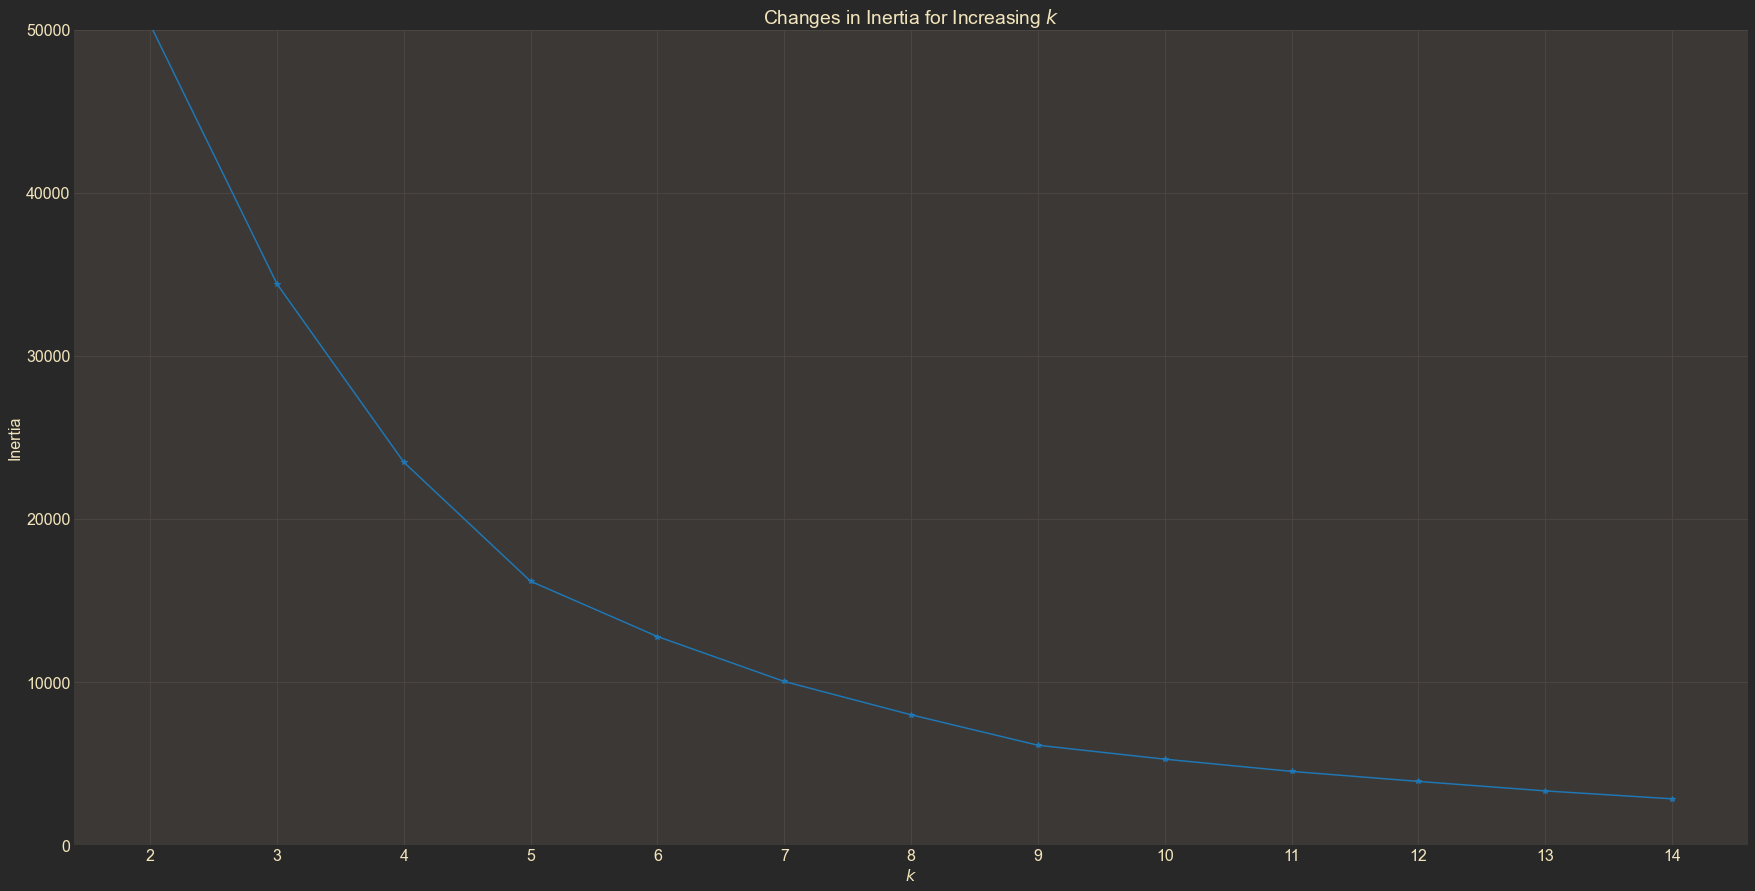

In [33]:
# create plot to use elbow method to find best k
explore.elbow_plot(explore_df, col_list)

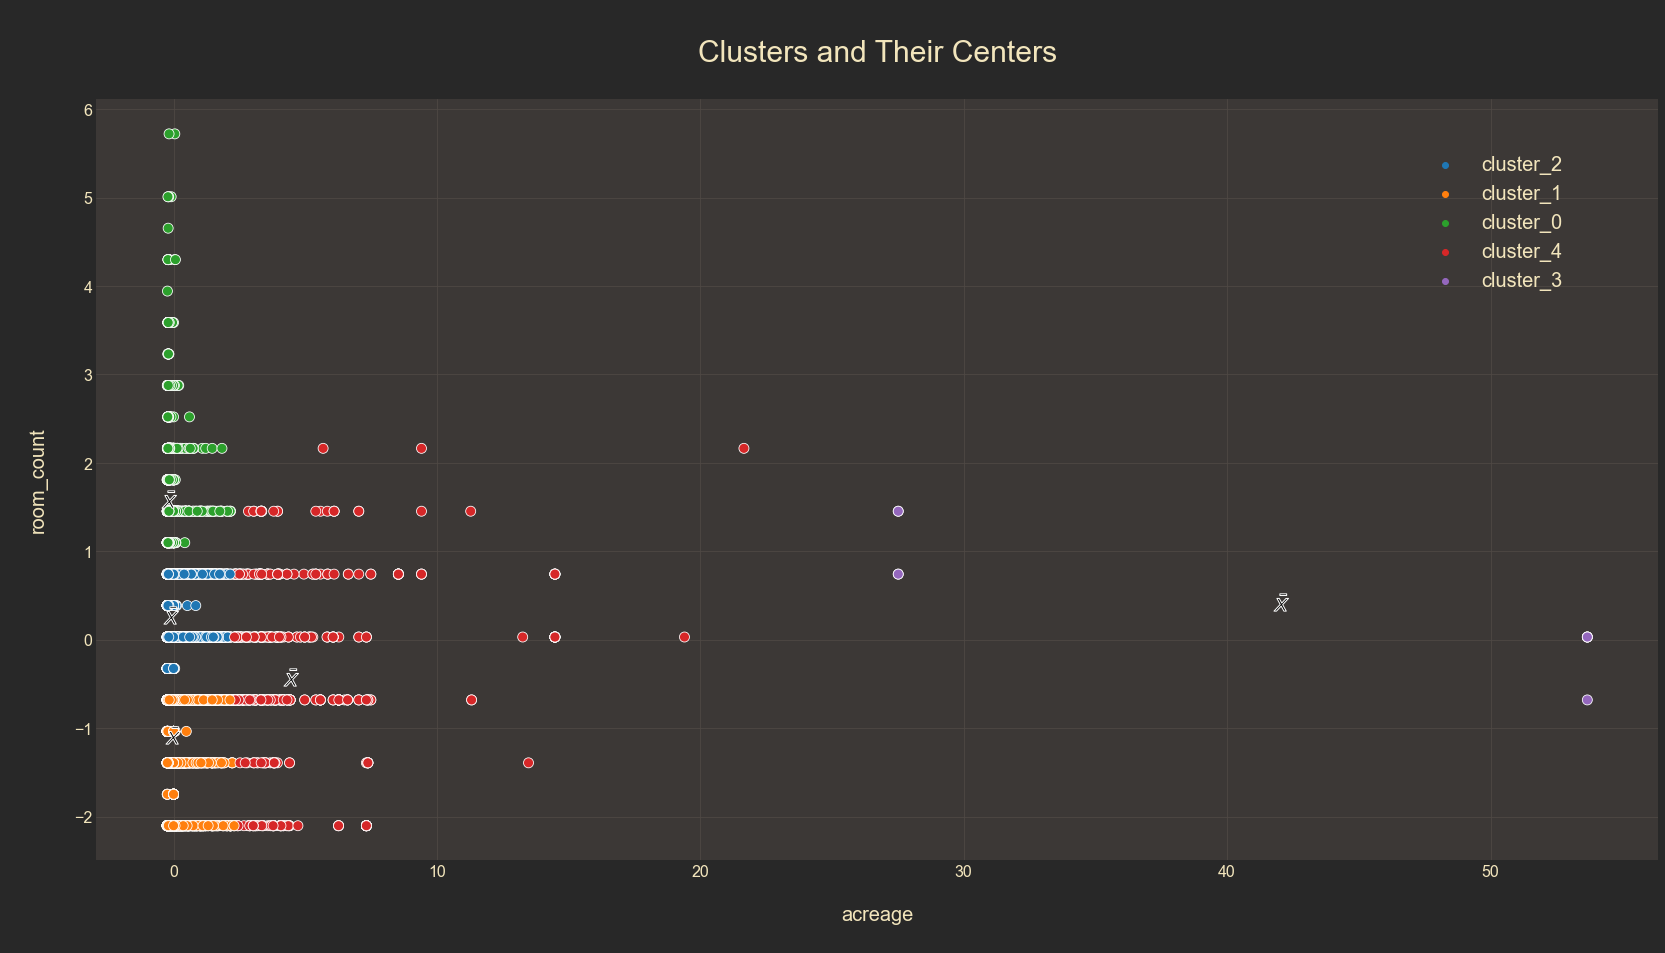

In [34]:
# create clusters for exploring log_error relative to location
cluster_df, center_df, kmeans = explore.explore_clusters(explore_df, col_list, k=5)
# create plot to view clusters for lot_rooms_clstr
explore.plot_clusters(cluster_df, center_df, 'acreage', 'room_count')

In [35]:
# set alpha for testing significance
alpha = 0.05
# create DataFrame of samples for ANOVA testing
samples = pd.concat((cluster_df, train.log_error), axis=1)
# Perform ANOVA one-way test for null hypotesis
F, p = stats.f_oneway(samples[samples.cluster == 0].log_error,
                      samples[samples.cluster == 1].log_error,
                      samples[samples.cluster == 2].log_error,
                      samples[samples.cluster == 3].log_error,
                      samples[samples.cluster == 4].log_error)
# print fail or succeed to reject and values returned
if p < alpha:
    state = '✓ May reject'
else:
    state = '𐄂 Fail to reject'
print(f'''
      Stats
+---------------+
| F-value: {F:.2f}|  {state}
| p-value: {p:.2f} |  the null hypothesis.
+---------------+
''')


      Stats
+---------------+
| F-value: 11.49|  ✓ May reject
| p-value: 0.00 |  the null hypothesis.
+---------------+



##### 🔥 Results

These results look more promising this time. Any modeling performed with this will need to be carefully considered, as this was the most heavily imputed variable with approximately $15\%$ of data imputed with the mean of the column. This clustering will carry into feature exploration, but precautions needed to be taken if it is carried into the modeling phase.

In [36]:
# add cluster to DataFrame for feature exploration
train['lot_rooms_clstr'] = cluster_df.cluster
train = pd.get_dummies(train, columns=['lot_rooms_clstr'], drop_first=True)

#### Bedrooms to Square Feet & Age

Again with clusters, this time to compare the relative size of the bedrooms and the year the property was constructed against the target. These will again be clustered using the elbow method to find the greatest decreases in inertia, and then ANOVA testing will be performed.

**Hypotheses and Significance Level**
- H$_0$: There is no significant difference in `log_error` between cluster groups for `bedrooms_per_sqft` and `age`.
- H$_a$: There is a  significant difference in `log_error` between cluster groups for `bedrooms_per_sqft` and `age`.
- $\alpha$: 0.05

In [37]:
# set col_list for cluster formation
col_list = ['bedrooms_per_sqft', 'age']
# create DataFrame for explored variables
explore_df = train[col_list]
# scale data for distance in kmeans
scaler = StandardScaler()
scaled = scaler.fit_transform(explore_df)
explore_df = pd.DataFrame(scaled, columns=explore_df.columns, index=explore_df.index)

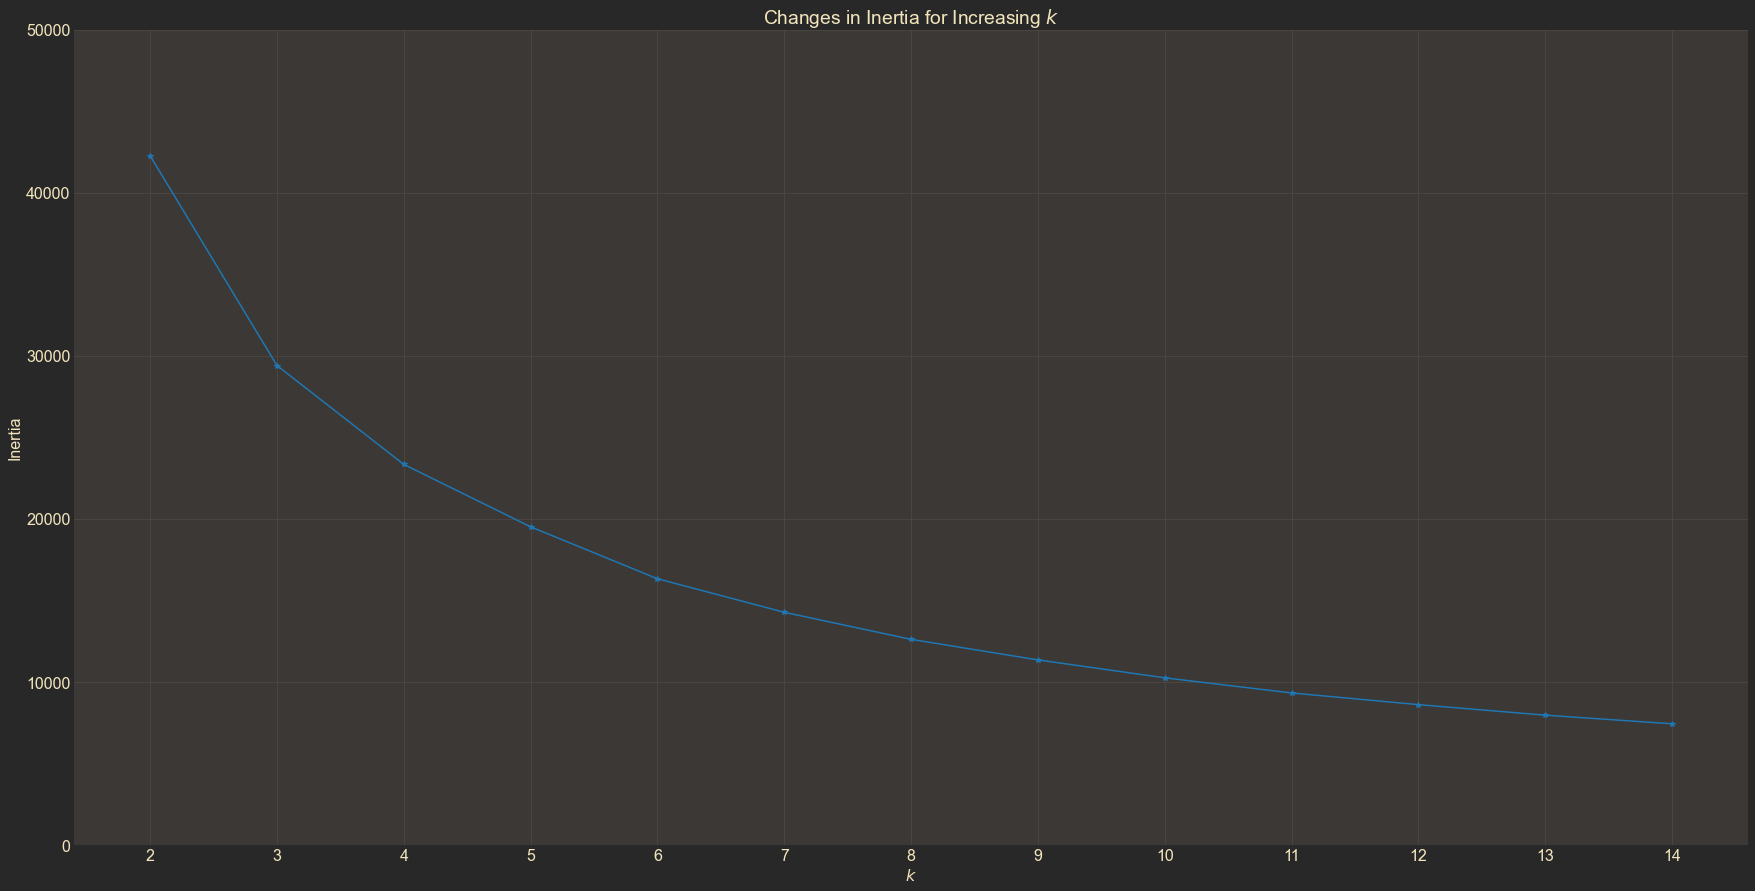

In [38]:
# create plot to use elbow method to find best k
explore.elbow_plot(explore_df, col_list)

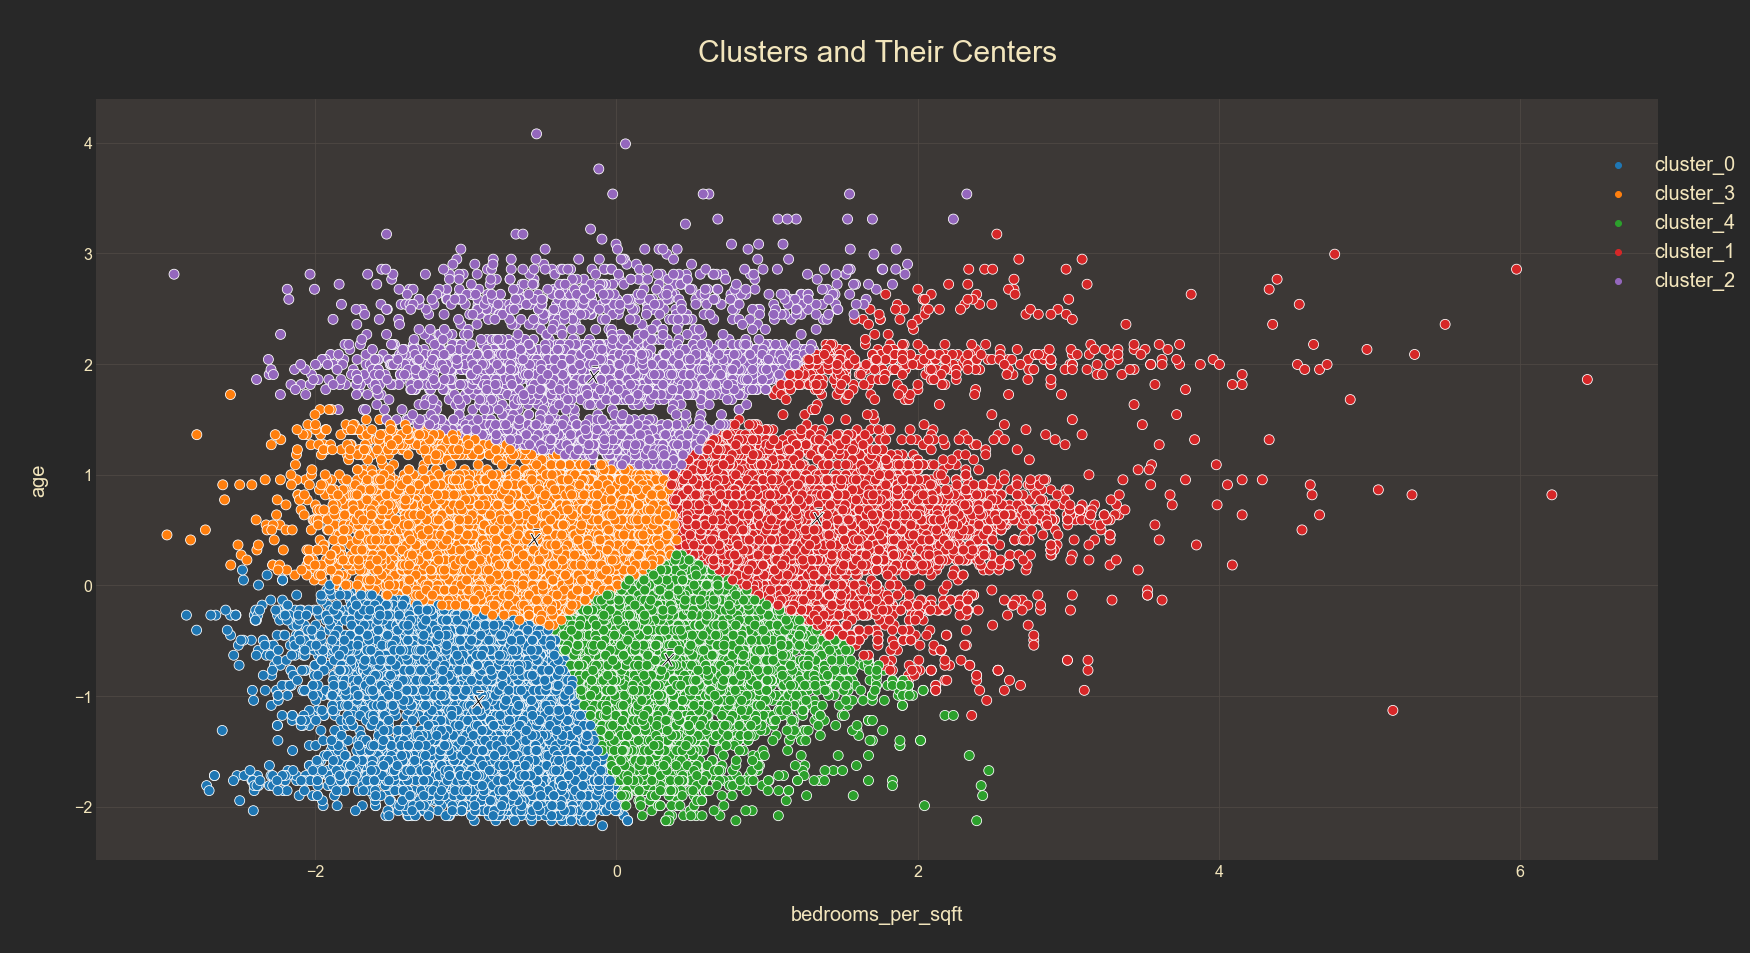

In [39]:
# create clusters for exploring log_error relative to location
cluster_df, center_df, kmeans = explore.explore_clusters(explore_df, col_list, k=5)
# create plot to view clusters for bed_sqft_age_clstr
explore.plot_clusters(cluster_df, center_df, 'bedrooms_per_sqft', 'age')

In [40]:
# set alpha for testing significance
alpha = 0.05
# create DataFrame of samples for ANOVA testing
samples = pd.concat((cluster_df, train.log_error), axis=1)
# Perform ANOVA one-way test for null hypotesis
F, p = stats.f_oneway(samples[samples.cluster == 0].log_error,
                      samples[samples.cluster == 1].log_error,
                      samples[samples.cluster == 2].log_error,
                      samples[samples.cluster == 3].log_error,
                      samples[samples.cluster == 4].log_error)
# print fail or succeed to reject and values returned
if p < alpha:
    state = '✓ May reject'
else:
    state = '𐄂 Fail to reject'
print(f'''
      Stats
+---------------+
| F-value: {F:.2f} |  {state}
| p-value: {p:.2f} |  the null hypothesis.
+---------------+
''')


      Stats
+---------------+
| F-value: 4.14 |  ✓ May reject
| p-value: 0.00 |  the null hypothesis.
+---------------+



##### 🔥 Results

This one is even more promising than the last statistical test. There is a higher F-value, which is inversely related to the p-value, and none of these values are imputed. `age` is created by subtracting `year_built` from the year $2017$, and the ratio `bedrooms_per_sqft` is calculated from `bedrooms` to `structure_square_feet`. This clustering will be carried into the feature exploration and- possibly -modeling phases.

In [41]:
# add cluster to DataFrame for feature exploration
train['bed_sqft_age_clstr'] = cluster_df.cluster
train = pd.get_dummies(train, columns=['bed_sqft_age_clstr'], drop_first=True)

#### Census Tract with Structure Dimensions & Age

As seen using only the latitude and longitude, the location itself did not carry any promising statistical significance in `log_error` variance. Here the `census_tractcode` will be used in conjunction with size of the property and its age as of $2017$ to find any meaningful groupings within those dimensions.

**Hypotheses and Significance Level**
- H$_0$: There is no significant difference in `log_error` between cluster groups for `census_tractcode`, `structure_square_feet`, and `age`.
- H$_a$: There is a  significant difference in `log_error` between cluster groups for `census_tractcode`, `structure_square_feet` and `age`.
- $\alpha$: 0.05

In [42]:
# set col_list for cluster formation
col_list = ['census_tractcode', 'structure_square_feet', 'age']
# create DataFrame for explored variables
explore_df = train[col_list]
# scale data for distance in kmeans
scaler = StandardScaler()
scaled = scaler.fit_transform(explore_df)
explore_df = pd.DataFrame(scaled, columns=explore_df.columns, index=explore_df.index)

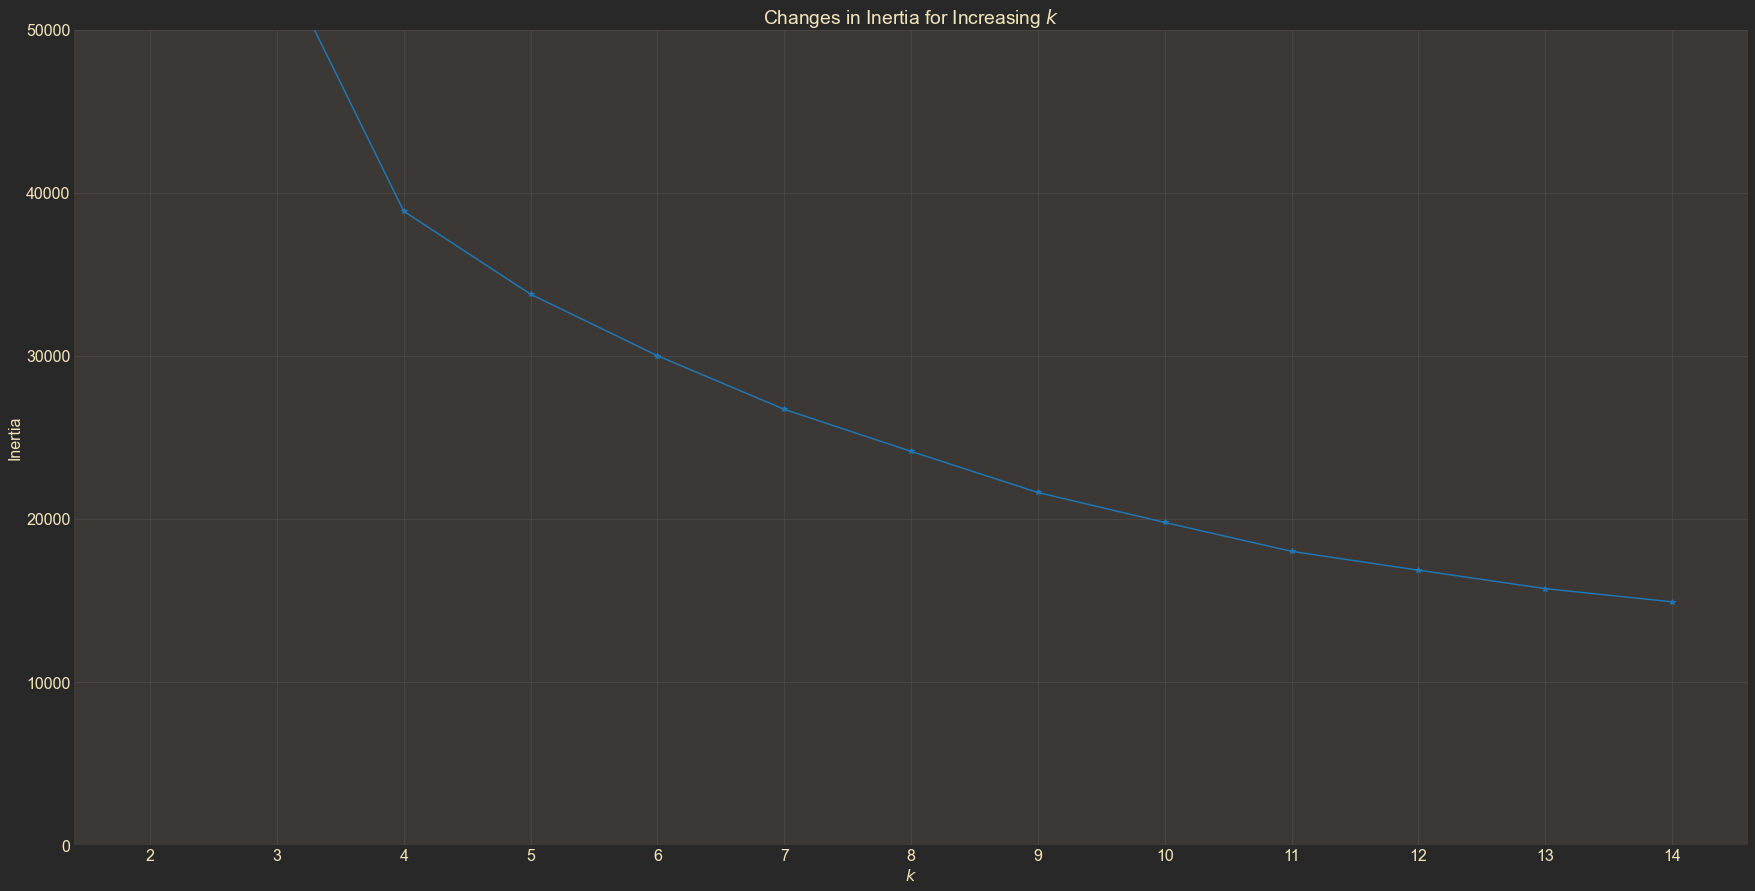

In [43]:
# create plot to use elbow method to find best k
explore.elbow_plot(explore_df, col_list)

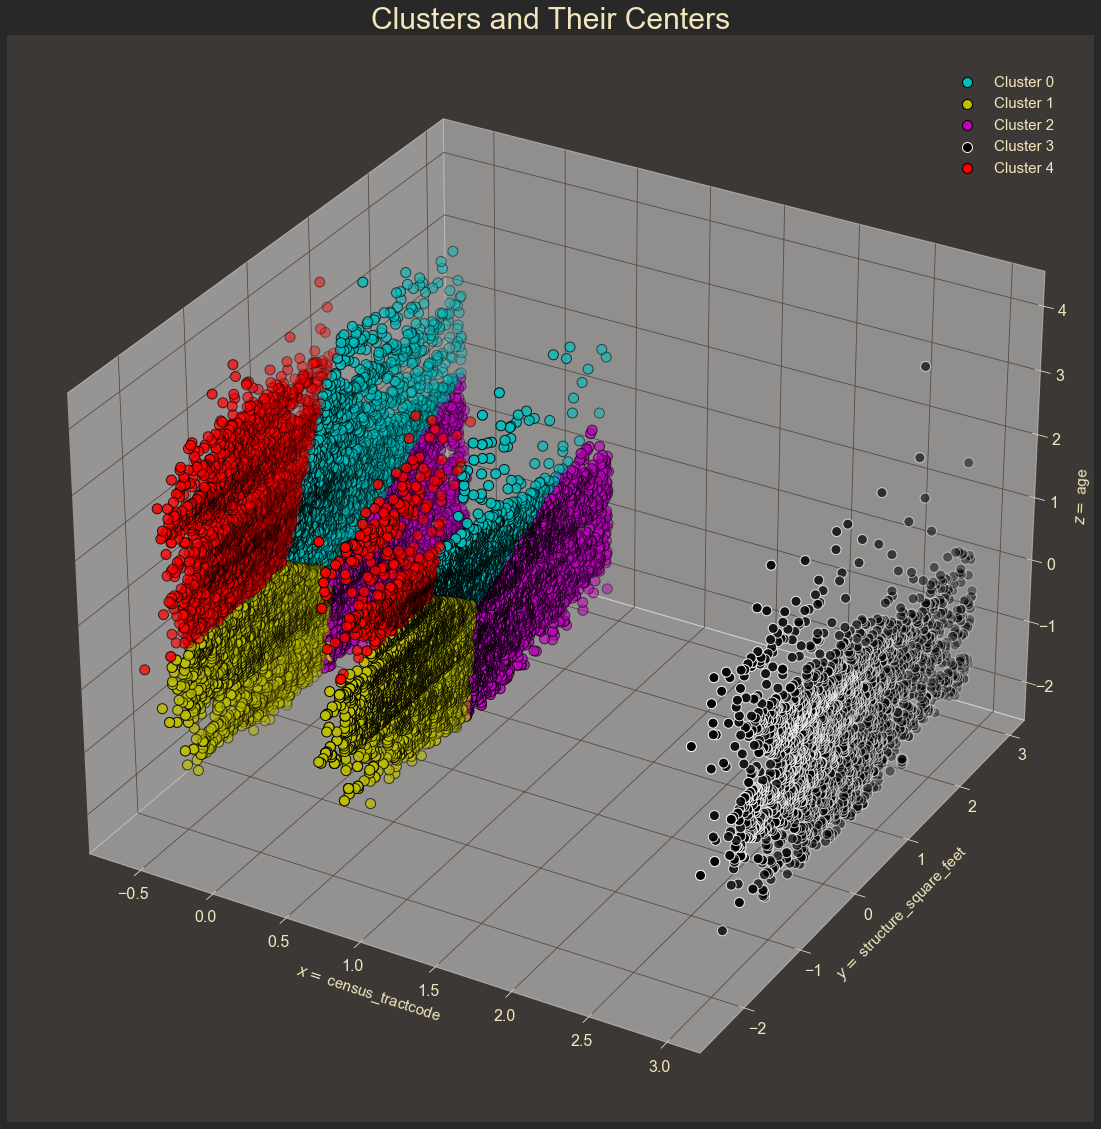

In [44]:
# create clusters for exploring log_error relative to location
cluster_df, center_df, kmeans = explore.explore_clusters(explore_df, col_list, k=5)
# create plot to view clusters for tract_size_age_clstr
explore.plot_three_d_clusters(cluster_df, center_df, 'census_tractcode', 'structure_square_feet', 'age')

In [45]:
# set alpha for testing significance
alpha = 0.05
# create DataFrame of samples for ANOVA testing
samples = pd.concat((cluster_df, train.log_error), axis=1)
# Perform ANOVA one-way test for null hypotesis
F, p = stats.f_oneway(samples[samples.cluster == 0].log_error,
                      samples[samples.cluster == 1].log_error,
                      samples[samples.cluster == 2].log_error,
                      samples[samples.cluster == 3].log_error,
                      samples[samples.cluster == 4].log_error)
# print fail or succeed to reject and values returned
if p < alpha:
    state = '✓ May reject'
else:
    state = '𐄂 Fail to reject'
print(f'''
      Stats
+---------------+
| F-value: {F:.2f} |  {state}
| p-value: {p:.2f} |  the null hypothesis.
+---------------+
''')


      Stats
+---------------+
| F-value: 7.18 |  ✓ May reject
| p-value: 0.00 |  the null hypothesis.
+---------------+



##### 🔥 Results

Using the `census_tractcode` as a variable for physical location, and adding the dimensions of property `age` and size of `structure_square_feet`, we can see this cluster also has a statistically significant difference in variance between clusters. This is another successful attempt to carry into feature exploration and possibly modeling.

In [46]:
# add cluster to DataFrame for feature exploration
train['tract_size_age_clstr'] = cluster_df.cluster
train = pd.get_dummies(train, columns=['tract_size_age_clstr'], drop_first=True)

### Feature Exploration

Before concluding exploration, it is best to spend a bit of time using algorithms to determine the best features for regression modeling. SelectKBest and recursive feature elimination (RFE) will be used to determine the the mathematically recommended features for modeling use. 

In [47]:
# set features into variables for different categories
room_features = ['bathrooms', 'bedrooms', 'full_bathrooms', 'room_count']
size_features = ['acreage', 'structure_square_feet']
loc_features = ['census_tractcode', 'latitude', 'longitude', 'la_county', 'orange_county']
usd_features = ['land_value_usd', 'property_value_usd', 'structure_value_usd', 'tax_amount_usd']
misc_features = ['age', 'bedrooms_per_sqft', 'transaction_month']
features = room_features + size_features + loc_features + usd_features + misc_features

In [48]:
# create scaler object
scaler = StandardScaler()
# fit scaler to training data
scaler.fit(train[features], y_train.log_error)
# transform to scaled data
scaled = pd.DataFrame(scaler.transform(train[features]), index=train.index, columns=train[features].columns)

In [49]:
# use RFE to find recommended non-cluster features
_ = explore.select_rfe(scaled, y_train.log_error, n=7, rank=True)

         n=7 RFE Rankings
1               bathrooms
1                bedrooms
1              room_count
1           orange_county
1          land_value_usd
1      property_value_usd
1     structure_value_usd
2               la_county
3        census_tractcode
4   structure_square_feet
5       bedrooms_per_sqft
6                 acreage
7                latitude
8          tax_amount_usd
9          full_bathrooms
10              longitude
11      transaction_month
12                    age


In [50]:
# use KBest to find recommended non-cluster features
explore.select_kbest(scaled, y_train.log_error, k=7)

['bathrooms',
 'bedrooms',
 'full_bathrooms',
 'room_count',
 'acreage',
 'structure_square_feet',
 'tax_amount_usd']

In [51]:
# add pared down features to cluster features
room_features = ['full_bathrooms', 'room_count']
size_features = ['acreage', 'structure_square_feet']
loc_features = ['census_tractcode', 'latitude', 'longitude', 'la_county', 'orange_county']
usd_features = ['land_value_usd', 'property_value_usd', 'structure_value_usd', 'tax_amount_usd']
misc_features = ['age', 'bedrooms_per_sqft', 'transaction_month']
clus1_features = ['lat_long_clstr_1', 'lat_long_clstr_2',
                  'lat_long_clstr_3', 'lat_long_clstr_4']
clus2_features = ['lot_rooms_clstr_1', 'lot_rooms_clstr_2',
                  'lot_rooms_clstr_3', 'lot_rooms_clstr_4']
clus3_features = ['bed_sqft_age_clstr_1', 'bed_sqft_age_clstr_2',
                  'bed_sqft_age_clstr_3', 'bed_sqft_age_clstr_4']
clus4_features = ['tract_size_age_clstr_1', 'tract_size_age_clstr_2',
                  'tract_size_age_clstr_3', 'tract_size_age_clstr_4']
features = room_features + size_features + loc_features + usd_features + misc_features + \
           clus1_features + clus2_features + clus3_features + clus4_features

In [52]:
# create scaler object
scaler = StandardScaler()
# fit scaler to training data
scaler.fit(train[features], y_train.log_error)
# transform to scaled data
scaled = pd.DataFrame(scaler.transform(train[features]), index=train.index, columns=train[features].columns)

In [53]:
# use RFE to find recommended features including clusters
_ = explore.select_rfe(scaled, y_train.log_error, n=7, rank=True)

          n=7 RFE Rankings
1        lot_rooms_clstr_2
1    structure_square_feet
1         census_tractcode
1        lot_rooms_clstr_1
1                la_county
1      structure_value_usd
1   tract_size_age_clstr_3
2       property_value_usd
3            orange_county
4           land_value_usd
5           full_bathrooms
6               room_count
7        bedrooms_per_sqft
8         lat_long_clstr_2
9           tax_amount_usd
10                 acreage
11    bed_sqft_age_clstr_4
12                latitude
13                     age
14  tract_size_age_clstr_1
15               longitude
16       lot_rooms_clstr_3
17       lot_rooms_clstr_4
18    bed_sqft_age_clstr_3
19  tract_size_age_clstr_2
20  tract_size_age_clstr_4
21    bed_sqft_age_clstr_2
22       transaction_month
23        lat_long_clstr_4
24    bed_sqft_age_clstr_1
25        lat_long_clstr_1
26        lat_long_clstr_3


In [54]:
# use KBest to find recommended features including clusters
explore.select_kbest(scaled, y_train.log_error, k=7)

['full_bathrooms',
 'room_count',
 'structure_square_feet',
 'lat_long_clstr_1',
 'lot_rooms_clstr_1',
 'tract_size_age_clstr_1',
 'tract_size_age_clstr_2']

## 🔹 Exploration Wrap-Up

In this notebook, the data has been acquired from the Codeup SQL database and read into a pandas DataFrame. From there, it was prepared by removing redundant and unnecessary data, as well as data without sufficient context and missing from a significant number of observations, $\approx25\%$ null-values. Continuous variables that were not to be imputed also had IQR outliers removed to prevent complications in scaling and modeling. The strongest correlations between variables and target all passed hypothesis testing, and some were used to create new features and clustering groups. Analysis of variance testing was used between cluster populations for `log_error`, and two of those created clusters showed statistically significant difference in variances. Finally, using RFE, features were explored to find possible best combinations of _lucky-number-seven_ features. This was done once using only non-cluster variables, and a second time using encoded cluster groupings.

**🔥 Key Takeaways**

- The four variables showing strongest correlation to the target showed statistical significant in hypothesis testing:
    - `bedrooms` Pearson $r \approx 0.02$
    - `structure_square_feet` Pearson $r \approx 0.019$
    - `land_value_usd` Pearson $r \approx 0.021$
    - `property_value_usd` Pearson $r \approx 0.023$
- Despite rejecting the null hypothesis, the correlation between the variables and the target is close to zero.
- The four cluster groups all showed statistically evident differences in `log_error` variance between populations.
    - ✓ `latitude` and `longitude`, $5$ clusters
    - ✓ `lot_square_feet` and `room_count`, $5$ clusters
    - ✓ `bedrooms_per_sqft` and `age`, $5$ clusters
    - ✓ `census_tractcode`, `structure_square_feet`, and `bed_sqft_age`, $5$ clusters
- Of the features recommended by RFE, it was mostly suggested to use variables related to structure size and room counts.
    - RFE recommendations were very different between with and without clusters; without clusters relying heavily on `usd_features`
        - Consideration needs to be taken when using features that contain tax values or payments, as they relate to the `log_error`
- `lot_rooms_clstr` and `tract_size_age_clstr` clusters had some groups recommended in both KBest and RFE

This concludes the notebook for phases through exploration. The remaining process including modeling and product delivery is contained in the related `model.ipynb` notebook.

In [55]:
end()


































 

































 

































 

































 

































 We cannot indulge ourselves in memories and destroy the present.
